In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis

%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
day_to_analyze = datetime.strptime("2020-10-22", "%Y-%m-%d")
env = "PAPER"

In [3]:
trades = analysis.load_trades(day_to_analyze, env)
algo_runs = analysis.load_runs(day_to_analyze, env)

[89322]2020-10-25 12:10:35.860865:db connection pool initialized


In [4]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
#batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_batch_revenue(x, trades, batch_id)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades, batch_id)
    )

    batch_time = (
        algo_runs.loc[algo_runs["batch_id"] == batch_id]
        .start_time.min()
        .tz_localize("utc")
        .astimezone(est)
    ) 
    
    env = algo_runs[algo_runs["batch_id"] == batch_id].algo_env.tolist()[0]
    print(
        f"[{env}] {batch_id}\n{batch_time}\nTotal revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

[PAPER] 76287005-8e55-47cd-b606-03737fa00214
2020-10-22 09:30:24.688337-04:00
Total revenues=$560.52


,symbol,revenues,count
0,AERI,41.76,2
1,DDD,32.20,2
2,DUST,18.48,2
3,ENLC,17.32,2
4,EQT,43.17,4
5,EVK,21.87,3
6,FRAN,-60.45,2
7,HA,56.25,2
8,HX,48.41,6
9,IH,45.65,2


[PAPER] 03ee5afc-31a7-4c9a-bae3-a214e5f6c7b1
2020-10-22 12:06:15.327402-04:00
Total revenues=$1378.28


,symbol,revenues,count
0,ALDX,3.37,2
1,AM,-104.89,2
2,AMRN,38.43,2
3,APA,-7.14,2
4,AR,39.44,2
5,ARR,-27.72,2
6,ATRA,40.71,2
7,AXL,62.86,2
8,BBD,46.65,2
9,BCLI,-92.64,2


In [5]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

AERI analysis with profit $41.76


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2476.89,-2476.89,buy,2020-10-22 10:43:56.364967-04:00,9.49,261,1.71%,0.3%,"{'buy': {'avg': 9.3582, 'macd': [0.01175118649149276, 0.017731023702401316, 0.02181515799923872, 0.02596295372469193, 0.029714497911587756], 'vwap': 9.495, 'macd_signal': [0.008628893237494849, 0.010449319330476142, 0.012722487064228658, 0.015370580396321313, 0.0182393638993746]}, 'sell': None}",10.55,9.14
1,41.76,2518.65,sell,2020-10-22 11:22:44.379021-04:00,9.65,261,3.43%,,"{'buy': None, 'sell': {'avg': 9.4377, 'rsi': [69.23081155942666, 66.2109667820814, 60.472177370338486], 'vwap': 9.65, 'reasons': 'bail', 'movement': 0.01685985247629085, 'sell_macd': [0.02190790597211567, 0.0218109956389565, 0.022485987643781513, 0.022205643911908268, 0.020659848225877298], 'sell_macd_signal': [0.022589502820509207, 0.022433801384198666, 0.022444238636115235, 0.02239651969127384, 0.022049185398194532]}}",10.55,9.14


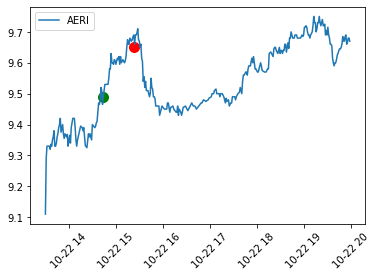

ALDX analysis with profit $3.37


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2510.65,-2510.65,buy,2020-10-22 12:18:59.780541-04:00,7.45,337,3.62%,0.85%,"{'buy': {'avg': 7.2511, 'macd': [0.034158441967854, 0.03413448712356626, 0.0375956679478584, 0.040317725084293876, 0.04072255360903121], 'vwap': 7.4552, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0417574241831056, 0.04023283677119773, 0.03970540300652987, 0.03982786742208267, 0.04000680465947238]}, 'sell': None}",8.27,7.16
1,3.37,2514.02,sell,2020-10-22 14:32:12.531008-04:00,7.46,337,3.76%,,"{'buy': None, 'sell': {'avg': 7.3232, 'rsi': [53.05347197925698, 54.23783748635781, 47.75117867385125], 'vwap': 7.46, 'reasons': 'bail post whipsawed', 'movement': 0.0013422818791946022, 'sell_macd': [0.006471710696464683, 0.0065808620510416915, 0.006060968794205479, 0.005836883544797722, 0.0042877666810410275], 'sell_macd_signal': [0.006212059761306043, 0.006285820219253173, 0.006240849934243634, 0.006160056656354452, 0.005785598661291767]}}",8.27,7.16


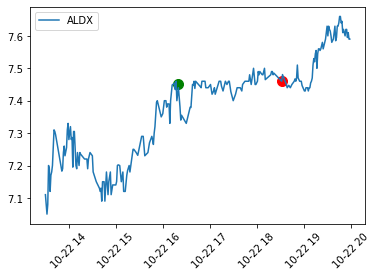

AM analysis with profit $-104.89


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-4078.37,-4078.37,buy,2020-10-22 12:52:34.092494-04:00,6.61,617,2.96%,1.36%,"{'buy': {'avg': 6.5076, 'macd': [-0.001997070907025389, -0.002302354565452802, -0.001318718063474833, -0.00013417415949223965, 0.0007954163539922732], 'vwap': 6.61, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [-0.0010151566122759076, -0.0012725962029112865, -0.0012818205750239958, -0.0010522912919176445, -0.0006827497627356609]}, 'sell': None}",7.07,6.46
1,-104.89,3973.48,sell,2020-10-22 13:37:06.284041-04:00,6.44,617,0.31%,,"{'buy': None, 'sell': {'avg': 6.5095, 'rsi': [26.619299005428726, 23.973546895054135, 20.656936921208473], 'vwap': 6.4482, 'reasons': 'stopped', 'movement': -0.024962178517397886, 'sell_macd': [-0.015371261165666006, -0.014688742002852528, -0.014485626525298834, -0.014658710224278337, -0.015216194791999094], 'sell_macd_signal': [-0.013972702700903986, -0.014115910561293694, -0.014189853754094723, -0.014283625048131446, -0.014470138996904976]}}",7.07,6.46


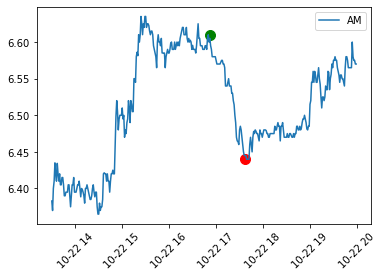

AMRN analysis with profit $38.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2723.04,-2723.04,buy,2020-10-22 10:17:33.290574-04:00,4.96,549,3.55%,1.84%,"{'buy': {'avg': 4.8781, 'macd': [0.009030936357474317, 0.009101322690759694, 0.010209445057968836, 0.011751028735321078, 0.014420348952786988], 'vwap': 4.96, 'macd_signal': [0.014490151921711264, 0.01341238607552095, 0.012771797872010528, 0.012567644044672638, 0.012938185026295509]}, 'sell': None}",5.47,4.79
1,38.43,2761.47,sell,2020-10-22 15:45:07.632319-04:00,5.03,549,5.01%,,"{'buy': {'reason': 'stopped', 'close_5m': [5.025, 5.0249, 5.035, 5.0399, 5.04]}, 'sell': {'liquidation': 1}}",4.81,5.02


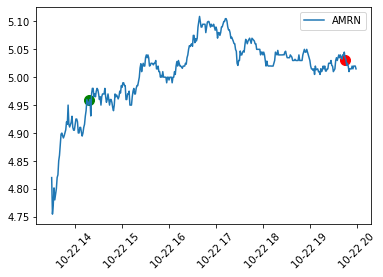

APA analysis with profit $-7.14


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3362.94,-3362.94,buy,2020-10-22 12:51:54.712526-04:00,9.42,357,3.29%,0.29%,"{'buy': {'avg': 9.146, 'macd': [-0.012000134451813693, -0.012370609351846085, -0.008930148269515215, -0.006531722654932182, -0.0033815974850437414], 'vwap': 9.4125, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.006743032244740798, -0.007868547666161855, -0.008080867786832526, -0.007771038760452457, -0.006893150505370714]}, 'sell': None}",10.21,9.16
1,-7.14,3355.80,sell,2020-10-22 14:25:49.648729-04:00,9.40,357,3.07%,,"{'buy': None, 'sell': {'avg': 9.1671, 'rsi': [75.49215466709727, 78.03265765245791, 79.1939939164337], 'vwap': 9.405, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.0015923566878981495, 'sell_macd': [0.009971696184196688, 0.01174082348499006, 0.014785067829956589, 0.018004153451620653, 0.02079819220289636], 'sell_macd_signal': [0.005399873838952363, 0.006668063768159902, 0.008291464580519239, 0.010234002354739521, 0.012346840324370889]}}",10.21,9.16


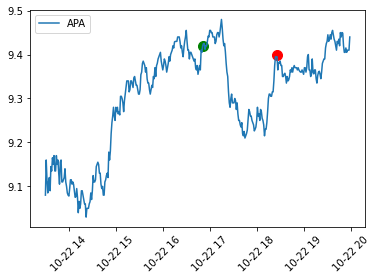

AR analysis with profit $39.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3953.86,-3953.86,buy,2020-10-22 12:50:06.059634-04:00,4.01,986,4.16%,2.74%,"{'buy': {'avg': 3.9556, 'macd': [-0.0009539844742167958, -0.0006397525830559303, -0.0004740181659581566, 0.00014784233935838387, 0.0002345097741285329], 'vwap': 4.0101, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.00029220855479975515, 0.00010581632722861804, -1.0150571408736885e-05, 2.1448010744687267e-05, 6.40603634214564e-05]}, 'sell': None}",4.29,3.91
1,39.44,3993.30,sell,2020-10-22 15:04:44.617860-04:00,4.05,986,5.19%,,"{'buy': None, 'sell': {'avg': 3.9652, 'rsi': [58.72003497686647, 58.720034976866486, 79.40294434899698], 'vwap': 4.0502, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01122194513715709, 'sell_macd': [0.003658000907897474, 0.003580259949971687, 0.0034731856976923936, 0.003344644907635086, 0.0055490982542441], 'sell_macd_signal': [0.003214608369666722, 0.003287738685727715, 0.0033248280881206507, 0.0033287914520235377, 0.00377285281246765]}}",4.29,3.91


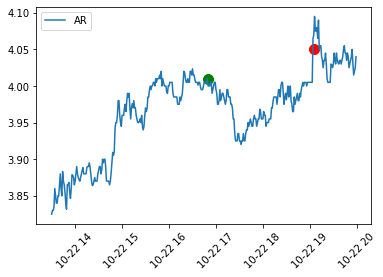

ARR analysis with profit $-27.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3027.64,-3027.64,buy,2020-10-22 10:16:23.297499-04:00,9.83,308,1.87%,0.89%,"{'buy': {'avg': 9.7361, 'macd': [0.015022177283162463, 0.016614156428355287, 0.017672098420419502, 0.019895020511974337, 0.02300534385422459], 'vwap': 9.83, 'macd_signal': [0.0218523552100104, 0.020804715453679377, 0.0201781920470274, 0.02012155774001679, 0.02069831496285835]}, 'sell': None}",10.73,9.53
1,-27.72,2999.92,sell,2020-10-22 15:24:42.211540-04:00,9.74,308,0.93%,,"{'buy': None, 'sell': {'avg': 9.7193, 'rsi': [77.98370216731445, 77.98370216731445, 81.59747947930735], 'vwap': 9.75, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.008138351983723303, 'sell_macd': [0.005517091766883198, 0.006391422439001815, 0.006989713580404455, 0.00736513896876545, 0.008081507596466864], 'sell_macd_signal': [0.004953407290187365, 0.0052410103199502555, 0.005590750972041095, 0.005945628571385966, 0.006372804376402146]}}",10.73,9.53


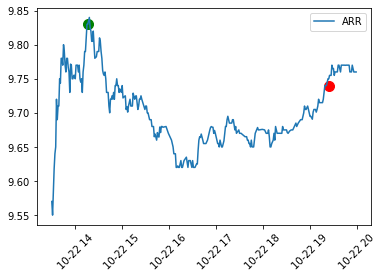

ATRA analysis with profit $40.71


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2531.10,-2531.10,buy,2020-10-22 10:57:16.166177-04:00,14.30,177,1.27%,0.41%,"{'buy': {'avg': 14.1784, 'macd': [-0.01443165241872535, -0.010252939739942235, -0.006463316533032781, -0.002224001296474043, 0.009099952251217402], 'vwap': 14.2975, 'macd_signal': [-0.011102035250908967, -0.010932216148715621, -0.010038436225579053, -0.00847554923975805, -0.00496044894156296]}, 'sell': None}",15.88,13.77
1,40.71,2571.81,sell,2020-10-22 12:23:12.701973-04:00,14.53,177,2.9%,,"{'buy': None, 'sell': {'avg': 14.3253, 'rsi': [58.156012424549516, 55.53214847574465, 55.53214847574465], 'vwap': 14.5538, 'reasons': 'bail', 'movement': 0.01748251748251748, 'sell_macd': [0.021306069987858223, 0.0225867718880135, 0.021473204902575205, 0.01954739679830375, 0.017990307407984574], 'sell_macd_signal': [0.01684160182085226, 0.017990635834284507, 0.018687149647942648, 0.01885919907801487, 0.01868542074400881]}}",15.88,13.77


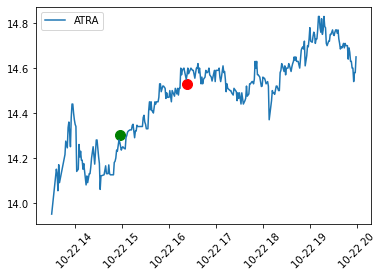

AXL analysis with profit $62.86


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3255.25,-3255.25,buy,2020-10-22 12:18:56.826659-04:00,7.25,449,2.55%,1.05%,"{'buy': {'avg': 7.1439, 'macd': [-0.005330101121358233, -0.003805362711741367, -0.0025674011348417736, -0.0015682300858772535, 0.0004290489990479429], 'vwap': 7.2507, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.0039050967080013323, -0.0038851499087493393, -0.0036216001539678263, -0.0032109261403497117, -0.0024829311124701806]}, 'sell': None}",7.88,7.05
1,62.86,3318.11,sell,2020-10-22 15:45:07.039945-04:00,7.39,449,4.53%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.88,7.05


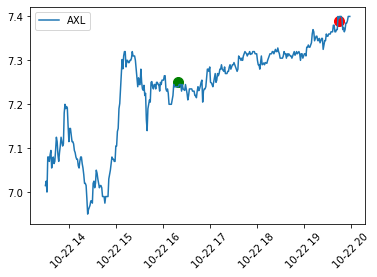

BBD analysis with profit $46.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3741.33,-3741.33,buy,2020-10-22 12:40:09.860079-04:00,4.01,933,2.35%,1.13%,"{'buy': {'avg': 3.962, 'macd': [0.0008853191816342587, 0.0006237988390589422, 0.0008106555639466606, 0.00134667544169087, 0.0017512873066847234], 'vwap': 4.0096, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0010658971466749015, 0.0009774774851517096, 0.0009441131009106998, 0.0010246255690667338, 0.0011699579165903317]}, 'sell': None}",4.31,3.91
1,46.65,3787.98,sell,2020-10-22 15:45:06.202359-04:00,4.06,933,3.63%,,"{'buy': None, 'sell': {'liquidation': 1}}",4.31,3.91


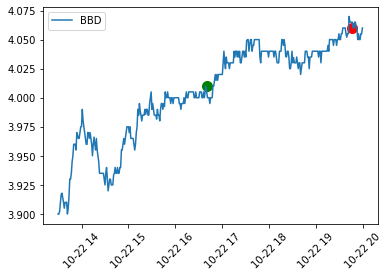

BCLI analysis with profit $-92.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2086.33,-2086.33,buy,2020-10-22 10:58:36.142231-04:00,10.81,193,5.21%,2.82%,"{'buy': {'avg': 10.5651, 'macd': [0.0068736925499912616, 0.005505792218080785, 0.008351958143585136, 0.014387535912643301, 0.02342751808597754], 'vwap': 10.825, 'macd_signal': [0.01510105883212216, 0.013182005509313885, 0.012215996036168134, 0.012650304011463168, 0.014805746826366043]}, 'sell': None}",12.27,10.34
1,-92.64,1993.69,sell,2020-10-22 12:06:30.378050-04:00,10.33,193,0.54%,,"{'buy': None, 'sell': {'avg': 10.5698, 'rsi': [37.11975764896201, 30.89648976647788, 30.89648976647788], 'vwap': 10.32, 'reasons': 'stopped', 'movement': -0.04532839962997227, 'sell_macd': [-0.010470358319452089, -0.013987091954986042, -0.017065233853390538, -0.023398003724182104, -0.028028759419289173], 'sell_macd_signal': [-0.01810714105470467, -0.017283131234760947, -0.017239551758486866, -0.018471242151625912, -0.020382745605158563]}}",12.27,10.34


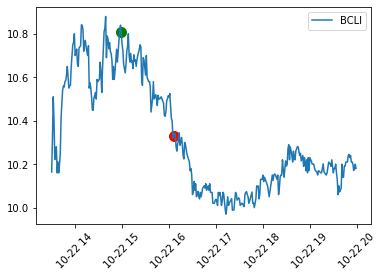

CAPR analysis with profit $-17.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2643.55,-2643.55,buy,2020-10-22 12:31:52.093967-04:00,4.55,581,6.06%,2.41%,"{'buy': {'avg': 4.3935, 'macd': [0.020710385868198955, 0.01930714632073638, 0.021976321645992947, 0.023011415457564688, 0.025953310432925925], 'vwap': 4.55, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.023275202531468357, 0.02248159128932196, 0.022380537360656157, 0.02250671298003786, 0.023196032470615476]}, 'sell': None}",5.03,4.39
1,-17.43,2626.12,sell,2020-10-22 15:47:50.165611-04:00,4.52,581,5.36%,,"{'buy': None, 'sell': {'liquidation': 1}}",5.03,4.39


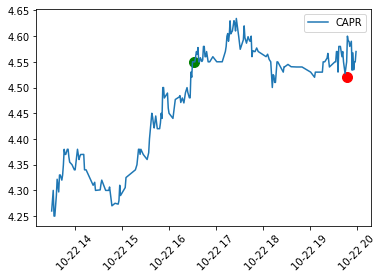

CLF analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3681.33,-3681.33,buy,2020-10-22 12:39:31.021302-04:00,8.31,443,3.91%,2.43%,"{'buy': {'avg': 8.1911, 'macd': [0.00021953398786145328, -0.00036199793288282933, -0.0008134887775348432, -0.00035225238770486555, 0.0012017334150140613], 'vwap': 8.315, 'reason': ['MACD zero-cross'], 'macd_signal': [0.005384155340938397, 0.0042349246861741515, 0.0032252419934323522, 0.0025097431172049086, 0.002248141176766739]}, 'sell': None}",8.95,8.10
1,0.00,3681.33,sell,2020-10-22 15:45:06.777888-04:00,8.31,443,3.91%,,"{'buy': None, 'sell': {'liquidation': 1}}",8.95,8.10


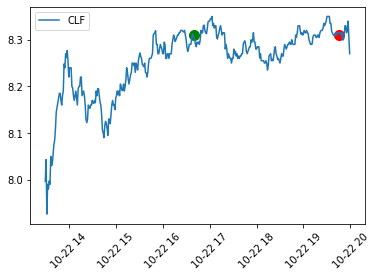

CLLS analysis with profit $48.60


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2885.22,-2885.22,buy,2020-10-22 10:54:32.197567-04:00,17.81,162,3.28%,1.56%,"{'buy': {'avg': 17.5138, 'macd': [0.01587455978397756, 0.018882415521613183, 0.02102381342977111, 0.028835748389951732, 0.036629876938356176], 'vwap': 17.8124, 'macd_signal': [0.02144350183287078, 0.02093128457061926, 0.02094979034244963, 0.02252698195195005, 0.025347560949231275]}, 'sell': None}",19.52,17.23
1,48.60,2933.82,sell,2020-10-22 12:43:25.848217-04:00,18.11,162,5.02%,,"{'buy': None, 'sell': {'avg': 17.6118, 'rsi': [63.90015479546839, 63.9001547954684, 58.04109303585675], 'vwap': 18.145, 'reasons': 'bail', 'movement': 0.01880965749578893, 'sell_macd': [0.04320892460700421, 0.04161980861596959, 0.04165920123833544, 0.04114886820071817, 0.03787914287009997], 'sell_macd_signal': [0.03973378462484842, 0.04011098942307265, 0.04042063178612521, 0.0405662790690438, 0.04002885182925504]}}",19.52,17.23


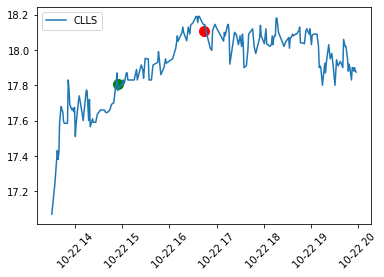

CLR analysis with profit $13.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3571.54,-3571.54,buy,2020-10-22 12:53:30.366648-04:00,13.58,263,2.8%,0.87%,"{'buy': {'avg': 13.3247, 'macd': [-0.008105539191557654, -0.005194869408045477, -0.0036529501257156483, -1.0102253510169135e-05, 0.002844095962643678], 'vwap': 13.5788, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [0.0006920957157262493, -0.00048529730902809607, -0.0011188278723656066, -0.0008970827485945191, -0.00014884700634687953]}, 'sell': None}",14.65,13.22
1,13.15,3584.69,sell,2020-10-22 14:32:19.142131-04:00,13.63,263,3.18%,,"{'buy': None, 'sell': {'avg': 13.3682, 'rsi': [65.49515961395286, 66.23811328523274, 63.302381091023996], 'vwap': 13.635, 'reasons': 'bail post whipsawed', 'movement': 0.004050073637702482, 'sell_macd': [0.028025890856348212, 0.026922250642225976, 0.026190553713790976, 0.02554000346158425, 0.024181912311012965], 'sell_macd_signal': [0.024560969783129816, 0.02503322595494905, 0.025264691506717434, 0.025319753897690797, 0.025092185580355232]}}",14.65,13.22


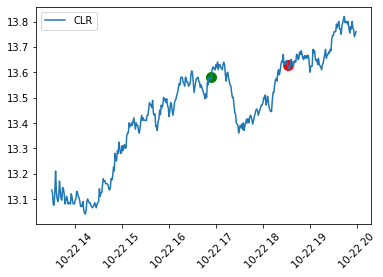

CLVS analysis with profit $40.53


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3277.14,-3277.14,buy,2020-10-22 12:57:56.848277-04:00,5.66,579,2.17%,0.97%,"{'buy': {'avg': 5.5938, 'macd': [-0.004855187842453645, -0.003963704996975181, -0.003220079348841942, -0.0018030498028824837, 0.00012542690466954554], 'vwap': 5.66, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.0069395063698121555, -0.006344346095244761, -0.005719492745964197, -0.004936204157347855, -0.003923877944944375]}, 'sell': None}",6.15,5.50
1,40.53,3317.67,sell,2020-10-22 13:13:57.674993-04:00,5.73,579,3.43%,,"{'buy': None, 'sell': {'avg': 5.5992, 'rsi': [68.47874046552387, 69.65905035884909, 80.2682323175073], 'vwap': 5.728, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.012367491166077788, 'sell_macd': [0.005689594860005975, 0.0066444753330374695, 0.007146401996008578, 0.007600547421752424, 0.009829744540232], 'sell_macd_signal': [0.0033205043173447947, 0.00398529852048333, 0.004617519215588379, 0.005214124856821188, 0.00613724879350335]}}",6.15,5.50


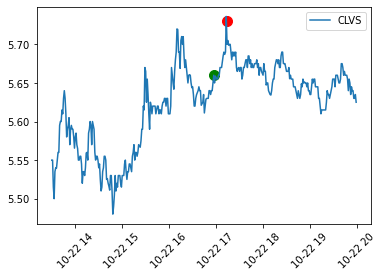

CNX analysis with profit $458.28


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3642.30,-3642.30,buy,2020-10-22 12:40:03.858979-04:00,10.65,342,3.7%,1.34%,"{'buy': {'avg': 10.408, 'macd': [-0.008332693664671709, -0.00629335077627502, -0.004224995512988272, -0.0025563411555626914, -0.0016187191814474033], 'vwap': 10.655, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.0029444529747773736, -0.0036142325350769027, -0.0037363851306591767, -0.0035003763356398795, -0.0031240449048013843]}, 'sell': None}",11.47,10.38
1,458.28,4100.58,sell,2020-10-22 15:04:24.462672-04:00,11.99,342,16.75%,,"{'buy': None, 'sell': {'avg': 10.6687, 'rsi': [68.01804266507061, 72.84703084080459, 97.4070346443265], 'vwap': 11.99, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.12582159624413145, 'sell_macd': [0.009457967868319983, 0.008889678164457848, 0.009526209847624756, 0.010937452589734775, 0.0724145579395632], 'sell_macd_signal': [0.00985095513090496, 0.009658699737615538, 0.009632201759617381, 0.00989325192564086, 0.022397513128425327]}}",11.47,10.38


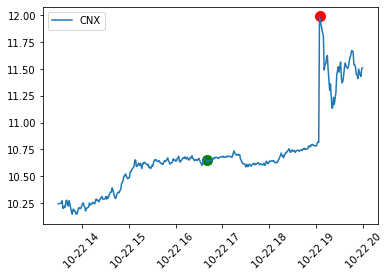

COG analysis with profit $-12.88


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3659.76,-3659.76,buy,2020-10-22 12:12:35.952984-04:00,19.89,184,2.76%,1.27%,"{'buy': {'avg': 19.6005, 'macd': [-0.0103710449999177, -0.007379314435503659, -0.00335582964075698, -0.0009630044637809476, 0.0025181321217573327], 'vwap': 19.89, 'reason': ['MACD histogram reversal'], 'macd_signal': [-0.002159018401530374, -0.0032030776083250313, -0.003233628014811421, -0.002779503304605326, -0.0017199762193327943]}, 'sell': None}",21.41,19.38
1,-12.88,3646.88,sell,2020-10-22 14:24:21.530820-04:00,19.82,184,2.4%,,"{'buy': None, 'sell': {'avg': 19.6731, 'rsi': [73.32705095754885, 77.97928086716396, 79.10087291073053], 'vwap': 19.821, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.0032679738562092146, 'sell_macd': [0.017449197301001362, 0.019302419959426942, 0.020495808784701808, 0.02297772463835912, 0.024924961347203123], 'sell_macd_signal': [0.009833025870483255, 0.011726904688271993, 0.013480685507557957, 0.01538009333371819, 0.017289066936415177]}}",21.41,19.38


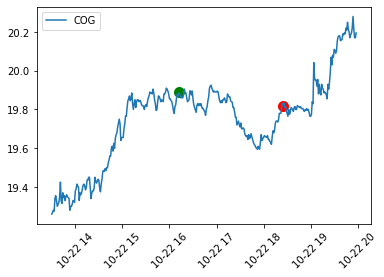

CRDF analysis with profit $21.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2450.37,-2450.37,buy,2020-10-22 12:08:22.900298-04:00,13.39,183,5.45%,2.89%,"{'buy': {'avg': 13.0647, 'macd': [-0.01384112237079016, -0.016204707030288645, -0.009894641370006951, -0.0016472150963373622, 0.00483321534709269], 'vwap': 13.3945, 'reason': ['MACD zero-cross'], 'macd_signal': [0.013940362659213595, 0.007911348721313147, 0.004350150703049126, 0.003150677543171829, 0.003487185103956001]}, 'sell': None}",14.92,12.89
1,21.96,2472.33,sell,2020-10-22 15:36:13.423087-04:00,13.51,183,6.39%,,"{'buy': None, 'sell': {'avg': 13.1603, 'rsi': [60.91233499722819, 54.4513097466316, 54.4513097466316], 'vwap': 13.5, 'reasons': 'bail post whipsawed', 'movement': 0.008215085884988755, 'sell_macd': [0.023861872783928817, 0.024159173012828106, 0.024077080035180387, 0.021622500052142613, 0.019429028636110957], 'sell_macd_signal': [0.01904551092524154, 0.020068243342758856, 0.02087001068124316, 0.02102050855542305, 0.020702212571560633]}}",14.92,12.89


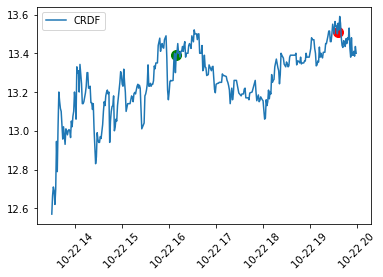

CRK analysis with profit $67.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3423.48,-3423.48,buy,2020-10-22 13:05:25.890370-04:00,6.07,564,3.06%,0.44%,"{'buy': {'avg': 5.9161, 'macd': [0.011607585289842959, 0.011229285593835847, 0.01160264867424221, 0.012560666487390293, 0.01356696914455835], 'vwap': 6.07, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.012051579462997888, 0.01188712068916548, 0.011830226286180825, 0.011976314326422719, 0.012294445290049845]}, 'sell': None}",6.57,5.90
1,67.68,3491.16,sell,2020-10-22 15:21:53.563181-04:00,6.19,564,5.09%,,"{'buy': None, 'sell': {'avg': 6.0212, 'rsi': [71.52281114177151, 72.33472846943584, 52.85880810163167], 'vwap': 6.19, 'reasons': 'bail', 'movement': 0.0197693574958814, 'sell_macd': [0.02128150380128968, 0.021755477489683095, 0.0221020092275257, 0.022344735137175498, 0.019126797727328615], 'sell_macd_signal': [0.017552210773035072, 0.018392864116364677, 0.01913469313859688, 0.019776701538312604, 0.019646720776115807]}}",6.57,5.90


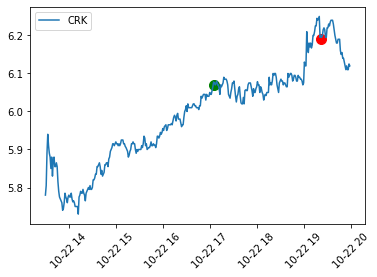

DDD analysis with profit $80.38


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2540.58,-2540.58,buy,2020-10-22 10:32:54.191556-04:00,7.89,322,3.41%,1.46%,"{'buy': {'avg': 7.7415, 'macd': [0.008128058690593853, 0.012144181727347991, 0.016636082320504286, 0.0208113767188971, 0.02430813014534383], 'vwap': 7.8903, 'macd_signal': [0.009460833890652151, 0.00999750345799132, 0.011325219230493913, 0.01322245072817455, 0.015439586611608406]}, 'sell': None}",8.76,7.61
1,32.20,2572.78,sell,2020-10-22 10:44:37.433219-04:00,7.99,322,4.72%,,"{'buy': None, 'sell': {'avg': 7.8033, 'rsi': [75.28919194695953, 75.28919194695953, 79.29823576079033], 'vwap': 8.0006, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.015209125475285185, 'sell_macd': [0.025591774911457144, 0.02739279548294693, 0.02818069728562822, 0.028428663660631237, 0.02958255091828743], 'sell_macd_signal': [0.018166878476202016, 0.020012061877551, 0.021645788959166443, 0.0230023638994594, 0.024318401303225008]}}",8.76,7.61
2,-3541.88,-3574.08,buy,2020-10-22 12:10:12.884966-04:00,8.16,438,6.95%,3.59%,"{'buy': {'avg': 7.9038, 'macd': [0.010407005148023174, 0.010523585822031833, 0.010407247765233052, 0.011394079797483414, 0.012835112531609738], 'vwap': 8.1504, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.011911995125725819, 0.011634313264987022, 0.011388900165036228, 0.011389936091525665, 0.01167897137954248]}, 'sell': None}",8.80,7.95
3,80.38,3622.26,sell,2020-10-22 12:37:53.567144-04:00,8.27,438,8.39%,,"{'buy': None, 'sell': {'avg': 7.9317, 'rsi': [73.35415409643801, 74.70270202788632, 79.50047143522212], 'vwap': 8.2652, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.013100490196078377, 'sell_macd': [0.010714327519490752, 0.010394529860514368, 0.010992161167019177, 0.011580027624464861, 0.012937066063715363], 'sell_macd_signal': [0.011824599850373289, 0.011538585852401504, 0.011429300915325038, 0.011459446257153002, 0.011754970218465475]}}",8.80,7.95


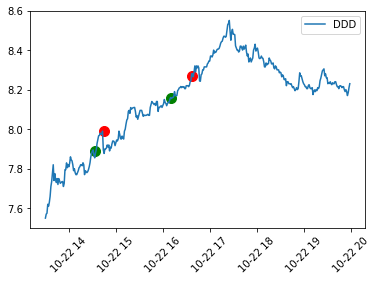

DTIL analysis with profit $-11.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3855.32,-3855.32,buy,2020-10-22 13:04:49.395312-04:00,6.86,562,2.08%,0.84%,"{'buy': {'avg': 6.7763, 'macd': [-0.0029481013269991863, -0.002969284357248192, -0.0025531823512361385, -0.0010014992143174695, 0.00022562004354487186], 'vwap': 6.86, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.003171501011977012, -0.003131057681031248, -0.003015482615072226, -0.002612685934921275, -0.0020450247392280454]}, 'sell': None}",7.36,6.69
1,-11.24,3844.08,sell,2020-10-22 15:47:32.163858-04:00,6.84,562,1.79%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.36,6.69


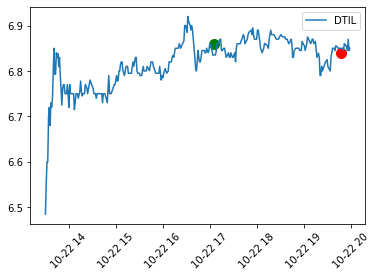

DUST analysis with profit $-38.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2477.64,-2477.64,buy,2020-10-22 10:02:12.349209-04:00,18.77,132,1.08%,-0.07%,"{'buy': {'avg': 18.5572, 'macd': [0.05129274388380267, 0.053466916762467065, 0.05576557737381549, 0.06693443594539872, 0.07807317772147826], 'vwap': 18.7612, 'macd_signal': [0.0669220942396854, 0.06423105874424173, 0.06253796247015649, 0.06341725716520494, 0.0663484412764596]}, 'sell': None}",20.90,18.07
1,18.48,2496.12,sell,2020-10-22 10:24:39.198308-04:00,18.91,132,1.83%,,"{'buy': None, 'sell': {'avg': 18.6014, 'rsi': [71.46617821563872, 73.89295804736709, 79.77400301720155], 'vwap': 18.9405, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.008524240809802885, 'sell_macd': [0.013919682058062932, 0.018028375647077155, 0.024455560578168445, 0.031109788309169772, 0.042670098381258015], 'sell_macd_signal': [0.0112464144627102, 0.01260280669958359, 0.01497335747530056, 0.018200643642074403, 0.023094534589911127]}}",20.90,18.07
2,-3702.85,-3721.33,buy,2020-10-22 12:25:32.200953-04:00,18.89,197,1.72%,0.95%,"{'buy': {'avg': 18.7469, 'macd': [0.0014347562766729993, 0.0012308948029300382, 0.001463984590706957, 0.004421944001748557, 0.006689041044566579], 'vwap': 18.89, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.003830590297921991, 0.0033106511989236, 0.0029413178772802716, 0.0032374431021739286, 0.003927762690652458]}, 'sell': None}",20.31,18.42
3,-38.65,3664.20,sell,2020-10-22 15:46:18.664810-04:00,18.60,197,0.16%,,"{'buy': None, 'sell': {'liquidation': 1}}",20.31,18.42


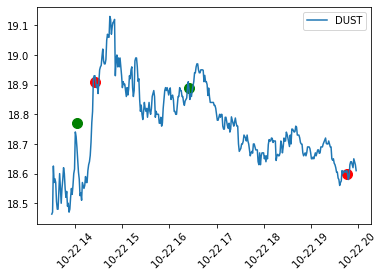

DVN analysis with profit $67.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3444.16,-3444.16,buy,2020-10-22 12:08:46.602203-04:00,9.16,376,4.57%,1.56%,"{'buy': {'avg': 8.8963, 'macd': [0.01954615697723483, 0.01983233908005566, 0.01902484825941464, 0.020967414160514508, 0.022649283009975818], 'vwap': 9.1599, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.019220105078102772, 0.01934255187849335, 0.01927901115467761, 0.01961669175584499, 0.020223210006671155]}, 'sell': None}",9.90,8.91
1,67.68,3511.84,sell,2020-10-22 15:39:29.034502-04:00,9.34,376,6.62%,,"{'buy': None, 'sell': {'avg': 9.0818, 'rsi': [69.64423612406672, 63.57865241462112, 55.737010048185695], 'vwap': 9.345, 'reasons': 'bail', 'movement': 0.020196506550218395, 'sell_macd': [0.0099119555460625, 0.010349886342806869, 0.010816457270882651, 0.010520065042488369, 0.009373265058771452], 'sell_macd_signal': [0.009433803244789336, 0.009617019864392843, 0.009856907345690804, 0.009989538885050317, 0.009866284119794544]}}",9.90,8.91


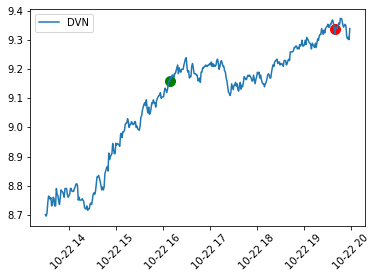

ENBL analysis with profit $19.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3211.00,-3211.00,buy,2020-10-22 12:35:22.466886-04:00,4.94,650,5.33%,2.3%,"{'buy': {'avg': 4.7977, 'macd': [0.007023855902027698, 0.006917361125658772, 0.006356234322228538, 0.007838471335811725, 0.010505882428097024], 'vwap': 4.9416, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.006560829787647808, 0.006632136055250001, 0.006576955708645709, 0.006829258834078912, 0.007564583552882535]}, 'sell': None}",5.37,4.80
1,19.50,3230.50,sell,2020-10-22 12:50:23.864061-04:00,4.97,650,5.97%,,"{'buy': None, 'sell': {'avg': 4.8232, 'rsi': [71.86963218015934, 80.86593106759821, 80.86593106759823], 'vwap': 4.98, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.008097165991902841, 'sell_macd': [0.010660440720754671, 0.010486423028272185, 0.010214637514282643, 0.011428640522677114, 0.012226192989962748], 'sell_macd_signal': [0.009107147302814993, 0.009383002447906432, 0.009549329461181675, 0.009925191673480762, 0.01038539193677716]}}",5.37,4.80


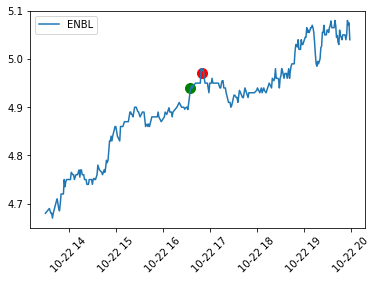

ENLC analysis with profit $17.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2476.76,-2476.76,buy,2020-10-22 10:39:25.662047-04:00,2.86,866,5.39%,3.34%,"{'buy': {'avg': 2.8044, 'macd': [0.008641086844246804, 0.008650317952804354, 0.008901991123864583, 0.009053564222286425, 0.010265724749856098], 'vwap': 2.8578, 'macd_signal': [0.0087042245120217, 0.00869344320017823, 0.0087351527849155, 0.008798835072389686, 0.009092213007882969]}, 'sell': None}",3.18,2.75
1,17.32,2494.08,sell,2020-10-22 10:51:37.256016-04:00,2.88,866,6.13%,,"{'buy': None, 'sell': {'avg': 2.814, 'rsi': [75.73401633537333, 75.73401633537333, 79.38228297122986], 'vwap': 2.88, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.006993006993007, 'sell_macd': [0.003689246485341968, 0.004310775154790392, 0.005258579635467164, 0.005928835339430005, 0.006893595169278566], 'sell_macd_signal': [0.004238600261848478, 0.004253035240436861, 0.004454144119442922, 0.0047490823634403385, 0.005177984924607984]}}",3.18,2.75


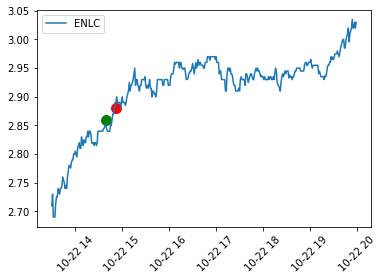

EQT analysis with profit $62.69


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1604.74,-1604.74,buy,2020-10-22 10:04:41.195812-04:00,15.58,103,3.01%,0.6%,"{'buy': {'avg': 15.2161, 'macd': [0.06839577963658527, 0.0854497097558351, 0.1038201711340978, 0.11623212610414235, 0.12702517200826158], 'vwap': 15.5855, 'macd_signal': [0.04518892679807228, 0.05324108338962484, 0.06335690093851944, 0.07393194597164401, 0.08455059117896753]}, 'sell': None}",18.30,14.69
1,3.09,1607.83,sell,2020-10-22 10:31:13.363158-04:00,15.61,103,3.21%,,"{'buy': None, 'sell': {'avg': 15.3443, 'rsi': [58.15251305399129, 59.31792596944692, 60.5025066945051], 'vwap': 15.5996, 'reasons': 'bail post whipsawed', 'movement': 0.0012836970474967633, 'sell_macd': [0.03981008516223383, 0.03542847899595003, 0.033632052385909716, 0.03257468032112776, 0.03208614779894425], 'sell_macd_signal': [0.04077972189673863, 0.03970947331658091, 0.038493989130446674, 0.03731012736858289, 0.036265331454655166]}}",18.30,14.69
2,-2620.48,-2623.57,buy,2020-10-22 10:47:15.296813-04:00,15.71,167,3.87%,1.81%,"{'buy': {'avg': 15.3994, 'macd': [0.04040034344454213, 0.042106685088706186, 0.043769412187824486, 0.04536306547416835, 0.04928557941105538], 'vwap': 15.7007, 'macd_signal': [0.04279932733699466, 0.04266079888733697, 0.04288252154743447, 0.04337863033278125, 0.044560020148436075]}, 'sell': None}",17.37,15.16
3,43.17,2663.65,sell,2020-10-22 10:57:29.350009-04:00,15.95,167,5.45%,,"{'buy': None, 'sell': {'avg': 15.4667, 'rsi': [69.09746754766583, 77.55526359770761, 79.14863353054673], 'vwap': 15.9678, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.017186505410566492, 'sell_macd': [0.04378380277814209, 0.04262688267938408, 0.042730232178023186, 0.049268813187635985, 0.05490837224463796], 'sell_macd_signal': [0.03554889576494735, 0.0369644931478347, 0.03811764095387239, 0.04034787540062511, 0.04325997476942768]}}",17.37,15.16
4,-3838.87,-3882.04,buy,2020-10-22 12:37:42.869554-04:00,15.91,244,5.19%,4.03%,"{'buy': {'avg': 15.7338, 'macd': [-0.023443918311714995, -0.02700731476724627, -0.025103909542750102, -0.019736809614240514, -0.014110314688892345], 'vwap': 15.925, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.021982974919000225, -0.022987842888649433, -0.023411056219469567, -0.022676206898423756, -0.020963028456517475]}, 'sell': None}",17.08,15.54
5,62.69,3901.56,sell,2020-10-22 14:34:11.515081-04:00,15.99,244,5.72%,,"{'buy': None, 'sell': {'avg': 15.7587, 'rsi': [67.15378386510233, 61.02630620265006, 61.02630620265006], 'vwap': 15.995, 'reasons': 'bail post whipsawed', 'movement': 0.005342551854179703, 'sell_macd': [0.024211126170726516, 0.02374528017697841, 0.024372604335395565, 0.023246199727209316, 0.022066583152945185], 'sell_macd_signal': [0.021558655550117895, 0.02199598047549, 0.022471305247471113, 0.022626284143418753, 0.02251434394532404]}}",17.08,15.54


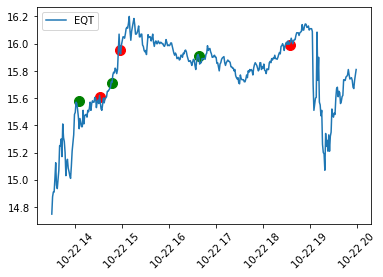

ERX analysis with profit $70.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3452.16,-3452.16,buy,2020-10-22 12:13:20.826739-04:00,9.28,372,4.5%,1.61%,"{'buy': {'avg': 9.0234, 'macd': [0.010797159893709107, 0.011412654645953424, 0.011764821136788228, 0.012704383816084075, 0.014492310316203572], 'vwap': 9.285, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.012825749430944717, 0.012543130473946458, 0.012387468606514813, 0.012450851648428666, 0.012859143381983646]}, 'sell': None}",10.04,9.03
1,-2363.11,1089.05,sell,2020-10-22 14:30:52.401881-04:00,9.47,115,6.64%,,"{'buy': None, 'sell': {'avg': 9.1445, 'rsi': [68.0759776515187, 65.93537779878119, 61.75308042177965], 'vwap': 9.4763, 'reasons': 'bail', 'movement': 0.02101293103448279, 'sell_macd': [0.02120708770844182, 0.02148708096074259, 0.020906724002006882, 0.01992324164452519, 0.018446200305648475], 'sell_macd_signal': [0.016593144239507203, 0.01757193158375428, 0.0182388900674048, 0.01857576038282888, 0.018549848367392797]}}",10.04,9.03
2,70.68,2433.79,sell,2020-10-22 14:30:52.545702-04:00,9.47,257,6.64%,,"{'buy': None, 'sell': {'avg': 9.1445, 'rsi': [68.0759776515187, 65.93537779878119, 61.75308042177965], 'vwap': 9.4763, 'reasons': 'bail', 'movement': 0.02101293103448279, 'sell_macd': [0.02120708770844182, 0.02148708096074259, 0.020906724002006882, 0.01992324164452519, 0.018446200305648475], 'sell_macd_signal': [0.016593144239507203, 0.01757193158375428, 0.0182388900674048, 0.01857576038282888, 0.018549848367392797]}}",10.04,9.03


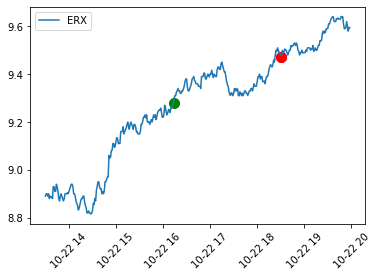

ET analysis with profit $61.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3115.08,-3115.08,buy,2020-10-22 10:51:41.150234-04:00,6.12,509,2.86%,1.07%,"{'buy': {'avg': 6.0137, 'macd': [-0.0016326346556709836, -0.0007825854027672108, 0.0014797903412775426, 0.002421768028591842, 0.004743582250521072], 'vwap': 6.12, 'macd_signal': [-5.004992942881373e-05, -0.00019655702409649315, 0.00013871244897831406, 0.0005953235649010197, 0.0014249753020250302]}, 'sell': None}",6.67,5.94
1,-1542.60,1572.48,sell,2020-10-22 12:33:19.372443-04:00,6.24,252,4.87%,,"{'buy': None, 'sell': {'avg': 6.0861, 'rsi': [61.16497909223805, 59.72318180109109, 55.045101989995395], 'vwap': 6.24, 'reasons': 'bail', 'movement': 0.01960784313725492, 'sell_macd': [0.006510703569907683, 0.007470745043393734, 0.007342585866325635, 0.007027882795021867, 0.006291388417446697], 'sell_macd_signal': [0.006389047431862778, 0.006605386954168969, 0.006752826736600302, 0.0068078379482846155, 0.0067045480421170315]}}",6.67,5.94
2,61.08,1603.68,sell,2020-10-22 12:33:19.466712-04:00,6.24,257,4.87%,,"{'buy': None, 'sell': {'avg': 6.0861, 'rsi': [61.16497909223805, 59.72318180109109, 55.045101989995395], 'vwap': 6.24, 'reasons': 'bail', 'movement': 0.01960784313725492, 'sell_macd': [0.006510703569907683, 0.007470745043393734, 0.007342585866325635, 0.007027882795021867, 0.006291388417446697], 'sell_macd_signal': [0.006389047431862778, 0.006605386954168969, 0.006752826736600302, 0.0068078379482846155, 0.0067045480421170315]}}",6.67,5.94


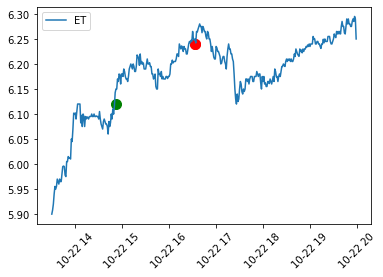

ETRN analysis with profit $-96.58


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3801.74,-3801.74,buy,2020-10-22 12:38:44.216763-04:00,8.66,439,6.32%,2.24%,"{'buy': {'avg': 8.3278, 'macd': [0.001941677407836906, 0.00175676842730077, 0.001990736964746276, 0.0037468007822347715, 0.005079935673062863], 'vwap': 8.6605, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.003832533658191335, 0.003417380612013222, 0.003132051882559833, 0.0032550016624948207, 0.003619988464608429]}, 'sell': None}",9.30,8.45
1,-96.58,3705.16,sell,2020-10-22 13:41:44.558413-04:00,8.44,439,3.62%,,"{'buy': None, 'sell': {'avg': 8.3673, 'rsi': [37.43946325742103, 33.88010244556956, 30.73351820773339], 'vwap': 8.44, 'reasons': 'stopped', 'movement': -0.02540415704387998, 'sell_macd': [-0.012482630092707225, -0.012310864619125894, -0.012017140034268792, -0.012411417759908616, -0.013336680692097147], 'sell_macd_signal': [-0.015552189262001467, -0.014903924333426351, -0.014326567473594839, -0.013943537530857595, -0.013822166163105505]}}",9.30,8.45


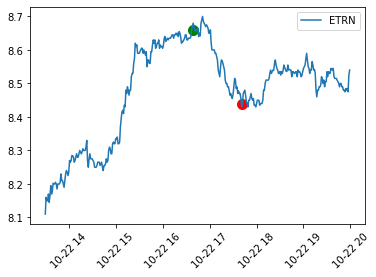

EVK analysis with profit $-77.31


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-277.83,-277.83,buy,2020-10-22 10:57:48.312657-04:00,5.67,49,61.53%,13.52%,"{'buy': {'avg': 3.9845, 'macd': [0.2595858217676934, 0.29987435874758983, 0.3240334762247441, 0.3620039132655375, 0.39120919683578226], 'vwap': 5.6727, 'macd_signal': [0.1905770816293261, 0.21243653705297885, 0.2347559248873319, 0.260205522562973, 0.2864062574175349]}, 'sell': {'avg': 3.6856, 'vwap': 3.4007, 'volume': [3229746.0, 798594.0, 708396.0, 465312.0, 558543.0], '5-min-close': [4.34, 3.995, 3.93, 3.74, 3.4], 'vwap_series': [3.6734498290049156, 3.8411172470711694, 3.8535823084477996, 3.8396695468322712, 3.8350447220749957]}}",11.30,3.81
1,-132.63,145.20,sell,2020-10-22 10:59:27.217509-04:00,6.05,24,72.36%,,"{'buy': None, 'sell': {'avg': 4.0093, 'rsi': [73.14115985638686, 74.14767946016644, 77.54586619978883], 'vwap': 5.9049, 'reasons': 'scale-out', 'movement': 0.05820105820105821, 'sell_macd': [0.1956330780818183, 0.21980840883352926, 0.235012453460401, 0.24796349533250428, 0.26547906698177304], 'sell_macd_signal': [0.1381256084734911, 0.1544621685454987, 0.17057222552847917, 0.1860504794892842, 0.20193619698778195]}}",11.30,3.81
2,21.87,154.50,sell,2020-10-22 11:00:34.229580-04:00,6.18,25,76.06%,,"{'buy': None, 'sell': {'avg': 4.0498, 'rsi': [74.14767946016644, 78.71180385912055, 79.6555982129225], 'vwap': 6.2564, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.029537190082644642, 'sell_macd': [0.21980840883352926, 0.235012453460401, 0.24796349533250428, 0.2769128332155386, 0.30270046230341574], 'sell_macd_signal': [0.1544621685454987, 0.17057222552847917, 0.1860504794892842, 0.20422295023453507, 0.2239184526483112]}}",11.30,3.81
3,-982.11,-1003.98,buy,2020-10-22 12:07:07.991894-04:00,5.77,174,64.38%,28.96%,"{'buy': {'avg': 4.5267, 'macd': [-0.035877783611659275, -0.03899002911734506, -0.041781788084849225, -0.03152710593021801, -0.019144923547755432], 'vwap': 5.7639, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.03677361535641334, -0.03721689810859968, -0.03812987610384959, -0.036809322069123275, -0.03327644236484971]}, 'sell': None}",7.38,5.23
4,-155.31,826.80,sell,2020-10-22 12:13:15.184820-04:00,5.20,159,48.14%,,"{'buy': None, 'sell': {'avg': 4.5355, 'rsi': [42.612504468275674, 41.49163823378624, 36.86676252908225], 'vwap': 5.2303, 'reasons': 'stopped', 'movement': -0.09878682842287685, 'sell_macd': [-0.0456759832016882, -0.053315864390472534, -0.05494024110393525, -0.05731066138580321, -0.06489136989913113], 'sell_macd_signal': [-0.031587380275449856, -0.03593307709845439, -0.03973450989955056, -0.04324974019680109, -0.0475780661372671]}}",7.38,5.23
5,-77.31,78.00,sell,2020-10-22 12:13:15.350680-04:00,5.20,15,48.14%,,"{'buy': None, 'sell': {'avg': 4.5355, 'rsi': [42.612504468275674, 41.49163823378624, 36.86676252908225], 'vwap': 5.2303, 'reasons': 'stopped', 'movement': -0.09878682842287685, 'sell_macd': [-0.0456759832016882, -0.053315864390472534, -0.05494024110393525, -0.05731066138580321, -0.06489136989913113], 'sell_macd_signal': [-0.031587380275449856, -0.03593307709845439, -0.03973450989955056, -0.04324974019680109, -0.0475780661372671]}}",7.38,5.23


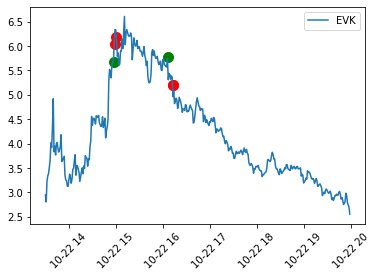

EVLO analysis with profit $13.53


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2178.33,-2178.33,buy,2020-10-22 12:46:20.189898-04:00,4.83,451,1.26%,-2.03%,"{'buy': {'avg': 4.6732, 'macd': [0.026022410756567638, 0.022811429823577534, 0.024822069493472654, 0.026114484397312232, 0.027627180012601116], 'vwap': 4.83, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.026141833493939615, 0.025475752759867198, 0.02534501610658829, 0.025498909764733076, 0.025924563814306682]}, 'sell': None}",5.45,4.62
1,13.53,2191.86,sell,2020-10-22 13:12:07.254025-04:00,4.86,451,1.89%,,"{'buy': None, 'sell': {'avg': 4.6809, 'rsi': [72.87769971777185, 54.481932708545656, 59.928396859028446], 'vwap': 4.91, 'reasons': 'bail', 'movement': 0.01656314699792962, 'sell_macd': [0.03433958766457046, 0.03495333254627031, 0.034977635927513795, 0.03038647445929321, 0.028492238581987905], 'sell_macd_signal': [0.02592941807189229, 0.027734200966767895, 0.029182887958917075, 0.029423605258992302, 0.029237331923591424]}}",5.45,4.62


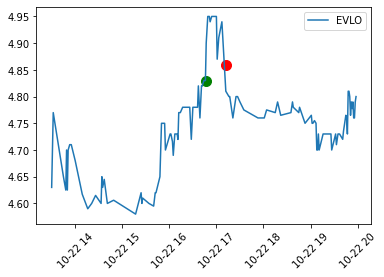

FHB analysis with profit $8.95


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3001.83,-3001.83,buy,2020-10-22 10:58:09.389630-04:00,16.77,179,3.26%,1.6%,"{'buy': {'avg': 16.4993, 'macd': [0.03502699773423501, 0.03927522222889124, 0.04335260355970405, 0.0460530863281754, 0.05003719007751428], 'vwap': 16.7623, 'macd_signal': [0.03397337658837681, 0.0350337457164797, 0.03669751728512457, 0.038568631093734734, 0.04086234289049064]}, 'sell': None}",18.33,16.25
1,8.95,3010.78,sell,2020-10-22 15:46:18.909543-04:00,16.82,179,3.57%,,"{'buy': None, 'sell': {'liquidation': 1}}",18.33,16.25


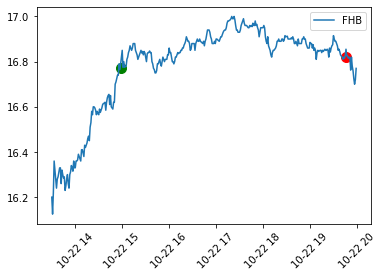

FNB analysis with profit $46.71


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-4048.20,-4048.20,buy,2020-10-22 13:09:11.010289-04:00,7.80,519,2.9%,1.98%,"{'buy': {'avg': 7.7304, 'macd': [-0.0022163641460464234, -0.002262029852656333, -0.0018731693110813907, -0.0011482994359317544, 0.00023042538859741057], 'vwap': 7.8, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.002699696042347736, -0.0026121628044094556, -0.0024643641057438426, -0.002201151171781425, -0.001714835859705658]}, 'sell': None}",8.34,7.62
1,46.71,4094.91,sell,2020-10-22 15:45:05.940056-04:00,7.89,519,4.09%,,"{'buy': None, 'sell': {'liquidation': 1}}",8.34,7.62


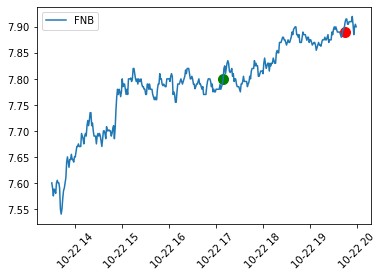

FRAN analysis with profit $-60.45


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-568.85,-568.85,buy,2020-10-22 09:47:11.905822-04:00,3.67,155,10.21%,1.46%,"{'buy': {'avg': 3.3785, 'macd': [0.10083032871119935, 0.10142618492300048, 0.1015348906738649, 0.11323447619748972, 0.12470014034052879], 'vwap': 3.6251, 'macd_signal': [0.07750026484495767, 0.08228544886056624, 0.08613533722322597, 0.09155516501807873, 0.09818416008256874]}, 'sell': None}",5.42,3.03
1,-60.45,508.40,sell,2020-10-22 10:07:38.252118-04:00,3.28,155,-1.5%,,"{'buy': None, 'sell': {'avg': 3.4708, 'rsi': [47.51576134907121, 45.41198330092602, 40.86545372455575], 'vwap': 3.29, 'reasons': 'below cost & macd negative & RSI trending down and too far from VWAP', 'movement': -0.10354223433242504, 'sell_macd': [0.019669568620633626, 0.012477703049988964, 0.007750564903382884, 0.0024079823878015993, -0.005422705057947397], 'sell_macd_signal': [0.03938795857359878, 0.034005907468876814, 0.028754838955778027, 0.02348546764218274, 0.017703833102156712]}}",5.42,3.03


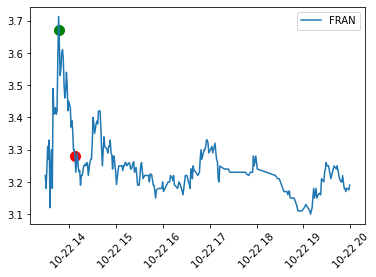

GEL analysis with profit $31.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1797.78,-1797.78,buy,2020-10-22 12:09:59.379923-04:00,4.98,361,1.63%,0.75%,"{'buy': {'avg': 4.9366, 'macd': [-0.0027426393103544555, -0.003449394591845234, -0.0033415886774372794, -0.0024213237738122118, -0.0016727250741208621], 'vwap': 4.98, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.002384257058954415, -0.0025972845655325787, -0.0027461453879135188, -0.0026811810650932575, -0.0024794898668987785]}, 'sell': None}",5.34,4.86
1,-3884.40,-2086.62,buy,2020-10-22 12:09:59.534147-04:00,4.98,419,1.63%,0.75%,"{'buy': {'avg': 4.9366, 'macd': [-0.0027426393103544555, -0.003449394591845234, -0.0033415886774372794, -0.0024213237738122118, -0.0016727250741208621], 'vwap': 4.98, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.002384257058954415, -0.0025972845655325787, -0.0027461453879135188, -0.0026811810650932575, -0.0024794898668987785]}, 'sell': None}",5.34,4.86
2,31.20,3915.60,sell,2020-10-22 15:45:07.263739-04:00,5.02,780,2.45%,,"{'buy': None, 'sell': {'liquidation': 1}}",5.34,4.86


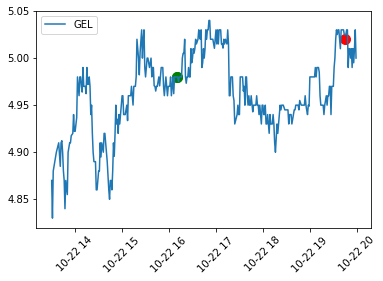

GES analysis with profit $71.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3816.96,-3816.96,buy,2020-10-22 12:08:57.137794-04:00,13.44,284,1.7%,0.55%,"{'buy': {'avg': 13.2872, 'macd': [0.004394533448246918, 0.004178030621430295, 0.0031630722172693027, 0.004724992872501943, 0.007490315404409031], 'vwap': 13.44, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.003944720262717291, 0.003991382334459892, 0.003825720311021774, 0.004005574823317808, 0.004702522939536052]}, 'sell': None}",14.43,13.11
1,71.00,3887.96,sell,2020-10-22 13:15:23.219292-04:00,13.69,284,3.59%,,"{'buy': None, 'sell': {'avg': 13.3773, 'rsi': [74.03533067738029, 76.25476700886622, 79.94674749197075], 'vwap': 13.6928, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01934523809523808, 'sell_macd': [0.016893481730102522, 0.01958042709395791, 0.021939340012623987, 0.024531488520512568, 0.027936649844575], 'sell_macd_signal': [0.015430199851067744, 0.016260245299645777, 0.017396064242241417, 0.018823149097895647, 0.020645849247231517]}}",14.43,13.11


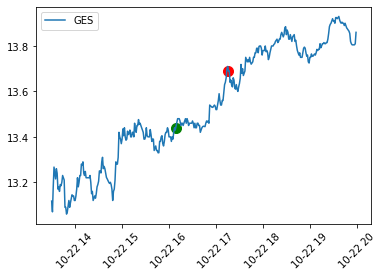

GME analysis with profit $-39.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-784.50,-784.50,buy,2020-10-22 09:51:59.750926-04:00,15.69,50,6.3%,2.18%,"{'buy': {'avg': 15.0815, 'macd': [0.2720759882674084, 0.2895916187499967, 0.28351763558108267, 0.3018606101857113, 0.3159747856145714], 'vwap': 15.695, 'macd_signal': [0.2572545890239344, 0.26372199496914683, 0.267681123091534, 0.27451702051036947, 0.28280857353120986]}, 'sell': None}",21.25,13.88
1,-39.00,745.50,sell,2020-10-22 15:45:12.544135-04:00,14.91,50,1.02%,,"{'buy': None, 'sell': {'liquidation': 1}}",21.25,13.88


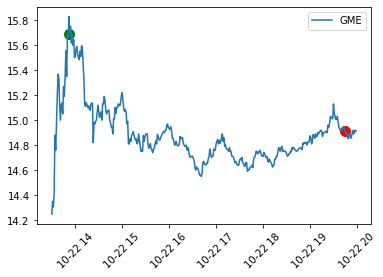

GT analysis with profit $-6.92


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-31.41,-31.41,buy,2020-10-22 12:45:24.704894-04:00,10.47,3,2.15%,0.49%,"{'buy': {'avg': 10.3001, 'macd': [0.00745426560377993, 0.007028633526109829, 0.006216202313963137, 0.0075031442153985495, 0.00882478651178964], 'vwap': 10.4716, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.007394718565731701, 0.007321501557807327, 0.007100441709038488, 0.007180982210310501, 0.007509743070606328]}, 'sell': None}",11.28,10.20
1,-3622.62,-3591.21,buy,2020-10-22 12:45:24.794877-04:00,10.47,343,2.15%,0.49%,"{'buy': {'avg': 10.3001, 'macd': [0.00745426560377993, 0.007028633526109829, 0.006216202313963137, 0.0075031442153985495, 0.00882478651178964], 'vwap': 10.4716, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.007394718565731701, 0.007321501557807327, 0.007100441709038488, 0.007180982210310501, 0.007509743070606328]}, 'sell': None}",11.28,10.20
2,-6.92,3615.70,sell,2020-10-22 15:45:13.513943-04:00,10.45,346,1.95%,,"{'buy': None, 'sell': {'liquidation': 1}}",11.28,10.20


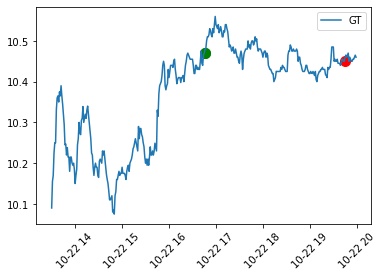

HA analysis with profit $115.99


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3289.50,-3289.50,buy,2020-10-22 10:49:29.242771-04:00,14.62,225,4.43%,3.07%,"{'buy': {'avg': 14.4304, 'macd': [0.0013597259384461324, 0.0034003245020706174, 0.0073534963168544465, 0.010765770572689348, 0.016108540766602175], 'vwap': 14.6061, 'macd_signal': [0.0031194037888407364, 0.0031755879314867125, 0.00401116960856026, 0.005362089801386078, 0.007511379994429298]}, 'sell': None}",15.86,14.21
1,56.25,3345.75,sell,2020-10-22 11:27:38.223779-04:00,14.87,225,6.21%,,"{'buy': None, 'sell': {'avg': 14.5285, 'rsi': [76.25906476511133, 66.03949695206117, 65.21797958194865], 'vwap': 14.8864, 'reasons': 'bail', 'movement': 0.018221614227086243, 'sell_macd': [0.03746017860141748, 0.038514851395531124, 0.03935596199619695, 0.03741713958117998, 0.03523861380868354], 'sell_macd_signal': [0.03324368165484131, 0.034297915602979276, 0.03530952488162281, 0.035731047821534245, 0.0356325610189641]}}",15.86,14.21
2,-3056.41,-3112.66,buy,2020-10-22 12:18:05.571401-04:00,15.11,206,7.93%,4.75%,"{'buy': {'avg': 14.6648, 'macd': [0.0316709243044091, 0.03318095210226879, 0.03358703140711938, 0.036314449307988994, 0.04043063769974786], 'vwap': 15.0986, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.03650037875912861, 0.03583649342775665, 0.03538660102362919, 0.035572170680501156, 0.036543864084350494]}, 'sell': None}",16.47,14.66
3,115.99,3172.40,sell,2020-10-22 13:41:58.817461-04:00,15.40,206,10.0%,,"{'buy': None, 'sell': {'avg': 14.8553, 'rsi': [74.97278149222562, 74.97278149222562, 79.7580424297029], 'vwap': 15.4332, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.021839841164791533, 'sell_macd': [0.02341209776971276, 0.024228471160451903, 0.025069431319984403, 0.025399147920657228, 0.027050886207927505], 'sell_macd_signal': [0.017394412842393136, 0.01876122450600489, 0.020022865868800793, 0.021098122279172078, 0.022288675064923165]}}",16.47,14.66


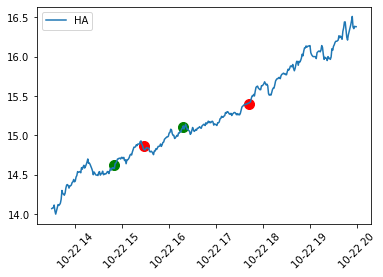

HBAN analysis with profit $56.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3008.61,-3008.61,buy,2020-10-22 10:22:31.427065-04:00,10.13,297,2.69%,1.3%,"{'buy': {'avg': 9.9936, 'macd': [0.022789500134130947, 0.023430501300406803, 0.02446341672925101, 0.02539275597715651, 0.02782579663033502], 'vwap': 10.13, 'macd_signal': [0.024492847442117723, 0.024280378213775537, 0.02431698591687063, 0.024532139928927808, 0.02519087126920925]}, 'sell': None}",11.07,9.82
1,-1254.21,1754.40,sell,2020-10-22 12:26:36.099936-04:00,10.32,170,4.61%,,"{'buy': None, 'sell': {'avg': 10.1107, 'rsi': [65.82137634634, 68.49907076938455, 60.80396982525682], 'vwap': 10.33, 'reasons': 'bail', 'movement': 0.019743336623889364, 'sell_macd': [0.01614055181311258, 0.01639765155096029, 0.015605811716152829, 0.015305601303108318, 0.01409367628900604], 'sell_macd_signal': [0.015246852818353777, 0.015477012564875079, 0.01550277239513063, 0.015463338176726167, 0.015189405799182142]}}",11.07,9.82
2,56.43,1310.64,sell,2020-10-22 12:26:36.219753-04:00,10.32,127,4.61%,,"{'buy': None, 'sell': {'avg': 10.1107, 'rsi': [65.82137634634, 68.49907076938455, 60.80396982525682], 'vwap': 10.33, 'reasons': 'bail', 'movement': 0.019743336623889364, 'sell_macd': [0.01614055181311258, 0.01639765155096029, 0.015605811716152829, 0.015305601303108318, 0.01409367628900604], 'sell_macd_signal': [0.015246852818353777, 0.015477012564875079, 0.01550277239513063, 0.015463338176726167, 0.015189405799182142]}}",11.07,9.82


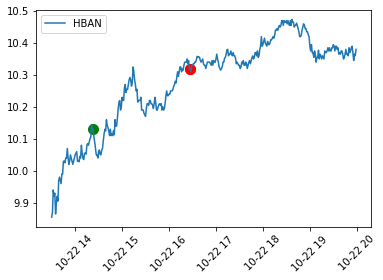

HX analysis with profit $92.81


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-739.35,-739.35,buy,2020-10-22 09:47:08.807644-04:00,2.65,279,8.91%,3.74%,"{'buy': {'avg': 2.5243, 'macd': [0.062207802731862216, 0.06149362857874596, 0.060871484970705936, 0.06458038687357259, 0.06834570446842703], 'vwap': 2.65, 'macd_signal': [0.04769056545460008, 0.050451178079429254, 0.05253523945768459, 0.05494426894086219, 0.05762455604637516]}, 'sell': None}",3.65,2.32
1,-354.32,385.03,sell,2020-10-22 09:54:59.632891-04:00,2.77,139,13.84%,,"{'buy': None, 'sell': {'avg': 2.5849, 'rsi': [66.18249510840903, 72.3557718011936, 76.27860033670085], 'vwap': 2.7587, 'reasons': 'scale-out', 'movement': 0.04101886792452839, 'sell_macd': [0.03932258809400091, 0.03798446172366354, 0.03697313647763867, 0.0393360890589487, 0.04372103796569782], 'sell_macd_signal': [0.03800566436940843, 0.03800142384025945, 0.037795766367735295, 0.03810383090597798, 0.039227272317921946]}}",3.65,2.32
2,4.08,358.40,sell,2020-10-22 09:58:05.768725-04:00,2.56,140,5.21%,,"{'buy': None, 'sell': {'avg': 2.6237, 'rsi': [72.47117114036519, 59.935031492422766, 52.63773575248641], 'vwap': 2.6238, 'reasons': 'bail', 'movement': -0.05415162454873643, 'sell_macd': [0.044827531472190874, 0.04644647969715665, 0.04866323831794572, 0.045291060122223836, 0.038947920487606424], 'sell_macd_signal': [0.03944857101922056, 0.04084815275480778, 0.042411169867435365, 0.04298714791839306, 0.042179302432235735]}}",3.65,2.32
3,-940.49,-944.57,buy,2020-10-22 10:19:36.195565-04:00,2.77,341,13.84%,8.34%,"{'buy': {'avg': 2.6362, 'macd': [0.008225986888376724, 0.01697502856411459, 0.024433964024431987, 0.031203968000185878, 0.036710905952697104], 'vwap': 2.7709, 'macd_signal': [0.012237971211780746, 0.013185382682247514, 0.01543509895068441, 0.018588872760584702, 0.022213279399007184]}, 'sell': {'avg': 2.6267, 'vwap': 2.62, 'volume': [9945.0, 8815.0, 10851.0, 12679.0, 2240.0], '5-min-close': [2.62, 2.78, 2.74, 2.6568, 2.62], 'vwap_series': [2.5398675631863976, 2.6323675925925927, 2.656978496444094, 2.657312746718776, 2.6572289309683934]}}",3.59,2.50
4,-447.49,493.00,sell,2020-10-22 11:18:46.201167-04:00,2.90,170,19.18%,,"{'buy': None, 'sell': {'avg': 2.6824, 'rsi': [59.20454425401981, 70.92445867717916, 78.05511308840464], 'vwap': 2.8847, 'reasons': 'scale-out', 'movement': 0.046931407942238226, 'sell_macd': [0.01063128301245131, 0.010857378500290782, 0.010892551886914958, 0.014705770735103929, 0.020815996191678288], 'sell_macd_signal': [0.00966889240167294, 0.009906589621396508, 0.010103782074500198, 0.011024179806620944, 0.012982543083632413]}}",3.59,2.50
5,48.41,495.90,sell,2020-10-22 11:19:54.150707-04:00,2.90,171,19.18%,,"{'buy': None, 'sell': {'avg': 2.6938, 'rsi': [70.92445867717916, 77.35568966024611, 79.14521266581485], 'vwap': 2.915, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.005172413793103492, 'sell_macd': [0.010857378500290782, 0.010892551886914958, 0.014705770735103929, 0.02109132086700294, 0.02709186225722293], 'sell_macd_signal': [0.009906589621396508, 0.010103782074500198, 0.011024179806620944, 0.013037608018697343, 0.01584845886640246]}}",3.59,2.50
6,-1650.63,-1699.04,buy,2020-10-22 12:25:44.268372-04:00,2.87,592,17.95%,20.1%,"{'buy': {'avg': 2.9222, 'macd': [-0.05038730398653701, -0.04746687179746445, -0.045036711286966735, -0.04261950050196717, -0.03864454047950927], 'vwap': 2.88, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.04391506201444011, -0.04462542397104498, -0.04470768143422933, -0.044290045247776896, -0.04316094429412337]}, 'sell': None}",3.35,2.72
7,-765.59,885.04,sell,2020-10-22 12:31:35.587617-04:00,2.99,296,22.88%,,"{'buy': None, 'sell': {'avg': 2.9225, 'rsi': [58.855650098209146, 60.007709095905916, 60.60172275994765], 'vwap': 2.99, 'reasons': 'scale-out', 'movement': 0.04181184668989551, 'sell_macd': [-0.019120521929174572, -0.014206529547165836, -0.008115022112520354, -0.002743522525621156, 0.001737431990477045

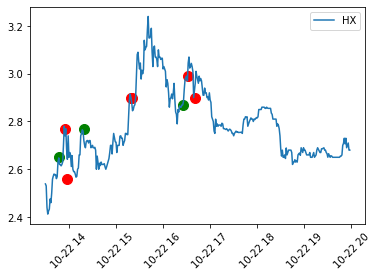

IDXG analysis with profit $17.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1241.00,-1241.00,buy,2020-10-22 10:16:44.258598-04:00,3.65,340,5.8%,3.34%,"{'buy': {'avg': 3.5653, 'macd': [0.024395855434257374, 0.026418053288224108, 0.03168993988847468, 0.036352643750340974, 0.04268664086433471], 'vwap': 3.6503, 'macd_signal': [0.022732121795272158, 0.023469308093862547, 0.025113434452784973, 0.027361276312296172, 0.03042634922270388]}, 'sell': None}",4.47,3.38
1,17.00,1258.00,sell,2020-10-22 14:58:15.214660-04:00,3.70,340,7.25%,,"{'buy': None, 'sell': {'avg': 3.581, 'rsi': [63.10578258546673, 59.70127080021656, 59.70127080021656], 'vwap': 3.7, 'reasons': 'bail', 'movement': 0.013698630136986375, 'sell_macd': [0.016366929116262252, 0.01681776850918304, 0.01643117883471623, 0.015397067674940867, 0.014391304853363707], 'sell_macd_signal': [0.014270426174620298, 0.014779894641532846, 0.015110151480169523, 0.015167534719123792, 0.015012288745971774]}}",4.47,3.38


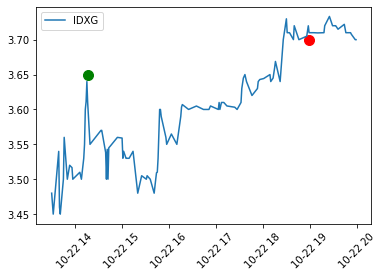

IH analysis with profit $45.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1543.80,-1543.80,buy,2020-10-22 10:40:57.279315-04:00,18.60,83,6.63%,3.83%,"{'buy': {'avg': 18.1116, 'macd': [0.10740083654302168, 0.11795209319604183, 0.1264700054661141, 0.14127497940459222, 0.1568483922691577], 'vwap': 18.7498, 'macd_signal': [0.06910799052072843, 0.07887681105579111, 0.08839544993785571, 0.098971355831203, 0.11054676311879394]}, 'sell': None}",22.09,17.64
1,45.65,1589.45,sell,2020-10-22 10:51:45.209009-04:00,19.15,83,9.79%,,"{'buy': None, 'sell': {'avg': 18.195, 'rsi': [67.95655831765147, 71.97135317376117, 80.11221182387412], 'vwap': 19.4228, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.04512903225806439, 'sell_macd': [0.08082085025766261, 0.08827822005531871, 0.09352450535147483, 0.10410181200625246, 0.13350098846443714], 'sell_macd_signal': [0.07811481279132995, 0.0801474942441277, 0.08282289646559712, 0.0870786795737282, 0.09636314135186999]}}",22.09,17.64


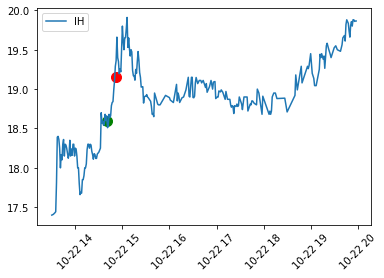

IMGN analysis with profit $-20.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1890.60,-1890.60,buy,2020-10-22 09:56:28.784803-04:00,5.48,345,1.86%,0.34%,"{'buy': {'avg': 5.3984, 'macd': [0.03687890411033745, 0.03715022000098411, 0.036540564701621925, 0.037640799840849226, 0.04006815443892453], 'vwap': 5.4735, 'macd_signal': [0.03344142428113995, 0.03418318342510878, 0.03465465968041141, 0.03525188771249897, 0.03621514105778408]}, 'sell': None}",6.30,5.22
1,-20.70,1869.90,sell,2020-10-22 13:12:12.660278-04:00,5.42,345,0.74%,,"{'buy': None, 'sell': {'avg': 5.3615, 'rsi': [77.20830941363549, 78.29671342727468, 79.13373675584126], 'vwap': 5.4289, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.009324817518248322, 'sell_macd': [0.007406647594263127, 0.008780475732789839, 0.010272023948100006, 0.01156060666200176, 0.012617156742159352], 'sell_macd_signal': [0.007388714953375338, 0.007667067109258238, 0.008188058477026592, 0.008862568114021625, 0.009613485839649171]}}",6.30,5.22


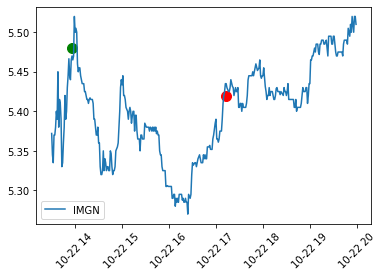

INO analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3721.72,-3721.72,buy,2020-10-22 12:32:23.160625-04:00,11.21,332,6.26%,3.1%,"{'buy': {'avg': 10.8769, 'macd': [0.011942942668177636, 0.011591604004959066, 0.011806462841411403, 0.013435694546991783, 0.014311751358521363], 'vwap': 11.2169, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01291200107649199, 0.012647921662185405, 0.012479629898030604, 0.01267084282782284, 0.012999024533962544]}, 'sell': None}",12.06,10.94
1,0.00,3721.72,sell,2020-10-22 15:46:27.537425-04:00,11.21,332,6.26%,,"{'buy': None, 'sell': {'liquidation': 1}}",12.06,10.94


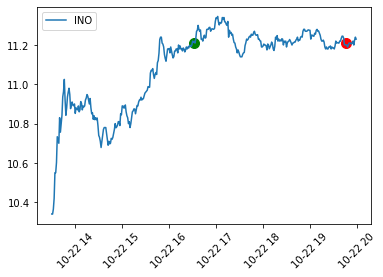

ISBC analysis with profit $33.18


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3848.88,-3848.88,buy,2020-10-22 12:39:32.020079-04:00,8.12,474,3.57%,1.82%,"{'buy': {'avg': 7.9828, 'macd': [0.010306143098958387, 0.010313340666371573, 0.010201448838374816, 0.010667613943638798, 0.011437770491138366], 'vwap': 8.125, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01076016540599293, 0.010670800458068659, 0.01057693013412989, 0.010595066896031671, 0.01076360761505301]}, 'sell': None}",8.72,7.93
1,33.18,3882.06,sell,2020-10-22 15:45:06.168347-04:00,8.19,474,4.46%,,"{'buy': None, 'sell': {'liquidation': 1}}",8.72,7.93


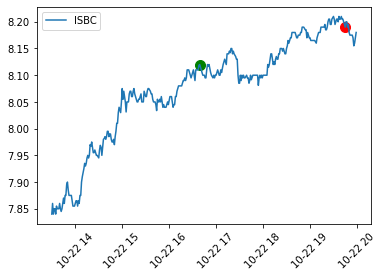

ITUB analysis with profit $50.76


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3823.92,-3823.92,buy,2020-10-22 12:14:49.358008-04:00,4.52,846,2.49%,1.25%,"{'buy': {'avg': 4.465, 'macd': [-0.00019327221555176521, -0.00032851542705092385, -3.187104372948113e-05, 0.000998626647405132, 0.0017946162726829584], 'vwap': 4.5154, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0006025392745160832, 0.0004163283342026818, 0.0003266884586162492, 0.00046107609637402577, 0.0007277841316358123]}, 'sell': None}",4.85,4.41
1,50.76,3874.68,sell,2020-10-22 13:08:56.296854-04:00,4.58,846,3.85%,,"{'buy': None, 'sell': {'avg': 4.4797, 'rsi': [77.15799435374208, 77.15799435374208, 80.33018961347265], 'vwap': 4.5899, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.015486725663716878, 'sell_macd': [0.004698584161360486, 0.004949418653155568, 0.006119556975941798, 0.0069518783056983224, 0.008024441961278939], 'sell_macd_signal': [0.0038305660141254106, 0.004054336541931442, 0.004467380628733513, 0.004964280164126475, 0.005576312523556968]}}",4.85,4.41


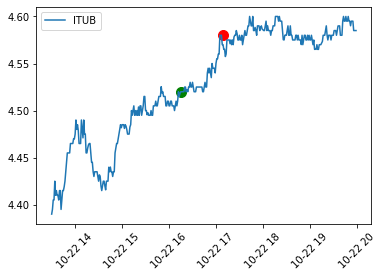

JBLU analysis with profit $81.11


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1633.57,-1633.57,buy,2020-10-22 10:16:31.321110-04:00,12.47,131,3.36%,1.42%,"{'buy': {'avg': 12.2361, 'macd': [0.05207840388939822, 0.05207389201024171, 0.05426096797944524, 0.055914534986891695, 0.059604201047005034], 'vwap': 12.4611, 'macd_signal': [0.05039308762852363, 0.05072924850486725, 0.05143559239978285, 0.052331380917204615, 0.0537859449431647]}, 'sell': None}",14.60,11.76
1,28.82,1662.39,sell,2020-10-22 11:18:35.305224-04:00,12.69,131,5.18%,,"{'buy': None, 'sell': {'avg': 12.3374, 'rsi': [76.96325763294541, 78.6869671674181, 79.0881758560274], 'vwap': 12.7, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01844426623897343, 'sell_macd': [0.027869629203181034, 0.029211516881138877, 0.03190374732005452, 0.034678163930637496, 0.036649421498225365], 'sell_macd_signal': [0.025496388171291674, 0.026239413913261116, 0.027372280594619797, 0.028833457261823337, 0.030396650109103744]}}",14.60,11.76
2,-1598.05,-1626.87,buy,2020-10-22 13:06:41.894117-04:00,12.81,127,6.17%,3.65%,"{'buy': {'avg': 12.5055, 'macd': [-0.011631018911868907, -0.01165089789134477, -0.008342815634337697, -0.0040604968787416595, 0.00013859042981678726], 'vwap': 12.8068, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [-0.0060983350591890615, -0.007208847625620203, -0.007435641227363702, -0.006760612357639294, -0.0053807718001480775]}, 'sell': None}",13.94,12.43
3,-3160.87,-1562.82,buy,2020-10-22 13:06:42.066538-04:00,12.81,122,6.17%,3.65%,"{'buy': {'avg': 12.5055, 'macd': [-0.011631018911868907, -0.01165089789134477, -0.008342815634337697, -0.0040604968787416595, 0.00013859042981678726], 'vwap': 12.8068, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [-0.0060983350591890615, -0.007208847625620203, -0.007435641227363702, -0.006760612357639294, -0.0053807718001480775]}, 'sell': None}",13.94,12.43
4,81.11,3241.98,sell,2020-10-22 13:46:57.747609-04:00,13.02,249,7.92%,,"{'buy': None, 'sell': {'avg': 12.5792, 'rsi': [69.96738666084423, 72.00410135102662, 79.49269606340947], 'vwap': 13.0203, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.016783762685402017, 'sell_macd': [0.01611436809374922, 0.016270501076510513, 0.016440598191955758, 0.0168791076560435, 0.019354840905254633], 'sell_macd_signal': [0.015857043980797618, 0.015939735399940196, 0.016039907958343307, 0.016207747897883346, 0.016837166499357605]}}",13.94,12.43


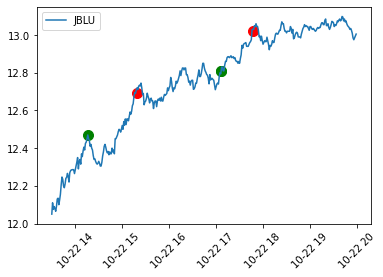

JDST analysis with profit $-36.54


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2430.19,-2430.19,buy,2020-10-22 10:01:58.370940-04:00,10.43,233,0.58%,-0.28%,"{'buy': {'avg': 10.3414, 'macd': [0.02451560103513195, 0.024140617237041084, 0.025167161358341517, 0.028077790953567217, 0.035606315098503316], 'vwap': 10.4399, 'macd_signal': [0.035760020016225136, 0.03343613946038833, 0.031782343839978966, 0.031041433262696615, 0.031954409629857954]}, 'sell': None}",11.64,10.04
1,23.30,2453.49,sell,2020-10-22 10:24:39.194201-04:00,10.53,233,1.54%,,"{'buy': None, 'sell': {'avg': 10.3659, 'rsi': [71.9618148749473, 73.6211776001969, 80.31311473912169], 'vwap': 10.5426, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.011505273250239789, 'sell_macd': [0.007228508909729925, 0.009861121092736624, 0.013893531610758458, 0.017634454980505865, 0.02409186987926404], 'sell_macd_signal': [0.006268506666780785, 0.006987029551971953, 0.008368329963729253, 0.010221554967084576, 0.012995617949520468]}}",11.64,10.04
2,-3679.74,-3703.04,buy,2020-10-22 12:13:51.707990-04:00,10.52,352,1.45%,0.97%,"{'buy': {'avg': 10.4709, 'macd': [-0.007130355033931224, -0.0070074072717432045, -0.004836922190008863, -0.0034801384685358983, -0.000782029986259758], 'vwap': 10.5201, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.002914764319427312, -0.0037332929098904907, -0.0039540187659141655, -0.003859242706438512, -0.003243800162402761]}, 'sell': None}",11.33,10.26
3,-36.54,3643.20,sell,2020-10-22 15:45:07.794383-04:00,10.35,352,-0.19%,,"{'buy': None, 'sell': {'liquidation': 1}}",11.33,10.26


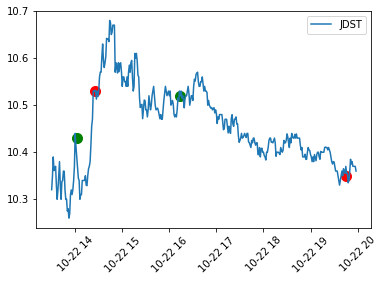

JMIA analysis with profit $5.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2096.77,-2096.77,buy,2020-10-22 10:20:19.110301-04:00,16.51,127,2.48%,0.51%,"{'buy': {'avg': 16.1922, 'macd': [0.057667494970488065, 0.06556891440472512, 0.0686190986975923, 0.0748217319903226, 0.0806155702454241], 'vwap': 16.52, 'macd_signal': [0.04128012885783893, 0.04613788596721617, 0.050634128513291396, 0.05547164920869764, 0.06050043341604293]}, 'sell': None}",18.71,15.79
1,5.08,2101.85,sell,2020-10-22 10:42:13.255779-04:00,16.55,127,2.73%,,"{'buy': None, 'sell': {'avg': 16.303, 'rsi': [58.025378071832165, 51.92398273268678, 51.92398273268677], 'vwap': 16.5395, 'reasons': 'bail post whipsawed', 'movement': 0.002119927316777719, 'sell_macd': [0.06741086763565107, 0.0660994551709706, 0.06421914084562275, 0.055426439542159756, 0.0475694458051521], 'sell_macd_signal': [0.04628505452066316, 0.05024793465072465, 0.053042175889704266, 0.053519028620195364, 0.05232911205718671]}}",18.71,15.79


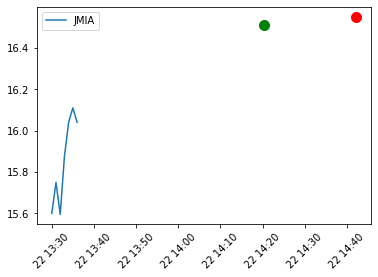

KEY analysis with profit $21.21


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3926.88,-3926.88,buy,2020-10-22 12:40:11.404051-04:00,12.96,303,4.52%,2.68%,"{'buy': {'avg': 12.7324, 'macd': [0.008827385556978484, 0.009441707578218939, 0.00981541619795756, 0.010794072054469694, 0.011836676249123101], 'vwap': 12.9607, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01061625332262272, 0.010381344173741962, 0.010268158578585082, 0.010373341273762004, 0.010666008268834223]}, 'sell': None}",13.89,12.66
1,21.21,3948.09,sell,2020-10-22 15:46:11.217450-04:00,13.03,303,5.08%,,"{'buy': None, 'sell': {'liquidation': 1}}",13.89,12.66


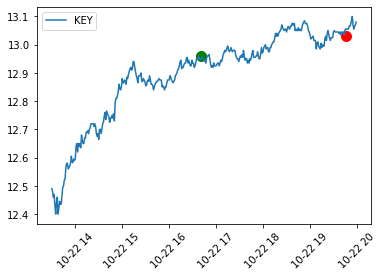

KIRK analysis with profit $63.48


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3096.72,-3096.72,buy,2020-10-22 13:03:07.775418-04:00,11.22,276,3.08%,1.88%,"{'buy': {'avg': 11.0891, 'macd': [-0.011387026492769792, -0.006381390762111749, -0.0023868739843919684, -2.7786776955807113e-05, 0.004612840371628124], 'vwap': 11.225, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.01549059693091591, -0.013668755697155078, -0.011412379354602455, -0.009135460839073125, -0.006385800596932875]}, 'sell': None}",12.24,10.89
1,63.48,3160.20,sell,2020-10-22 13:51:38.686145-04:00,11.45,276,5.19%,,"{'buy': None, 'sell': {'avg': 11.1335, 'rsi': [63.61310115959743, 62.33677330819659, 58.28851835663479], 'vwap': 11.4605, 'reasons': 'bail', 'movement': 0.021434937611408113, 'sell_macd': [0.025549902364266686, 0.026032697106760594, 0.026590294346279464, 0.026315820840109083, 0.024591350304909554], 'sell_macd_signal': [0.025817533459769768, 0.025860566189167933, 0.026006511820590238, 0.026068373624494007, 0.025772968960577118]}}",12.24,10.89


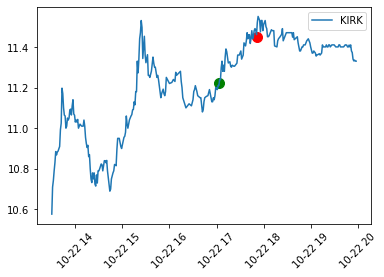

LXU analysis with profit $62.30


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2207.20,-2207.20,buy,2020-10-22 12:31:36.070773-04:00,2.48,890,12.31%,7.01%,"{'buy': {'avg': 2.3631, 'macd': [0.015341801362449115, 0.014201339357835074, 0.01633685956096853, 0.019020394084095837, 0.020906121769348474], 'vwap': 2.485, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.017214249597653962, 0.016611667549690186, 0.016556705951945853, 0.01704944357837585, 0.017820779216570375]}, 'sell': None}",2.80,2.38
1,62.30,2269.50,sell,2020-10-22 13:13:16.611223-04:00,2.55,890,15.48%,,"{'buy': None, 'sell': {'avg': 2.4148, 'rsi': [70.8966338244673, 75.4330908653907, 80.30866211124682], 'vwap': 2.5799, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.04012096774193545, 'sell_macd': [0.013180882099407487, 0.013573511711240993, 0.013703177490445917, 0.01466521345488525, 0.01677764130438497], 'sell_macd_signal': [0.011205856500908556, 0.011679387542975043, 0.012084145532469217, 0.012600359116952424, 0.013435815554438933]}}",2.80,2.38


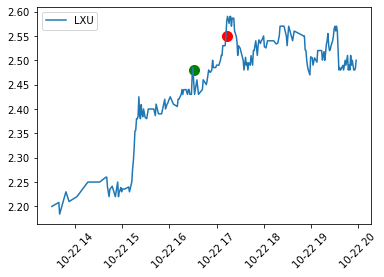

MDRX analysis with profit $-24.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3989.07,-3989.07,buy,2020-10-22 12:58:59.321370-04:00,11.43,349,1.96%,0.89%,"{'buy': {'avg': 11.3097, 'macd': [0.006593745056155953, 0.005635613519494598, 0.005219577546105469, 0.006828443065003853, 0.00880885402066589], 'vwap': 11.43, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0057769071067605825, 0.005748648389307385, 0.005642834220667002, 0.005879955989534372, 0.006465735595760675]}, 'sell': None}",12.24,11.16
1,-24.43,3964.64,sell,2020-10-22 14:59:20.185403-04:00,11.36,349,1.34%,,"{'buy': None, 'sell': {'avg': 11.3247, 'rsi': [74.51928988023977, 77.19061225255331, 79.50457511043896], 'vwap': 11.3583, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.006124234470691188, 'sell_macd': [0.001704187692059378, 0.002009944352625581, 0.004040274940695809, 0.0060893601399616415, 0.008038136137571428], 'sell_macd_signal': [0.0005176442154047546, 0.00081610424284892, 0.001460938382418298, 0.0023866227339269666, 0.003516925414655859]}}",12.24,11.16


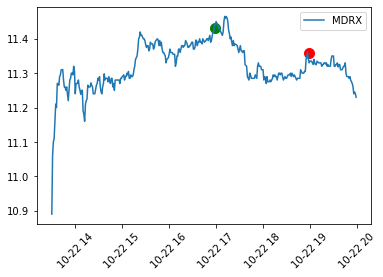

MNKD analysis with profit $15.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3286.50,-3286.50,buy,2020-10-22 12:50:47.049689-04:00,2.10,1565,4.74%,4.19%,"{'buy': {'avg': 2.0891, 'macd': [-0.003059641128637658, -0.003314267699108253, -0.003483969226410366, -0.002779502112741916, -0.002195893951176142], 'vwap': 2.1, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.0028770342569144755, -0.002964480945353231, -0.003068378601564658, -0.00301060330380011, -0.0028476614332753163]}, 'sell': None}",2.28,2.04
1,15.65,3302.15,sell,2020-10-22 15:45:20.439909-04:00,2.11,1565,5.24%,,"{'buy': None, 'sell': {'liquidation': 1}}",2.28,2.04


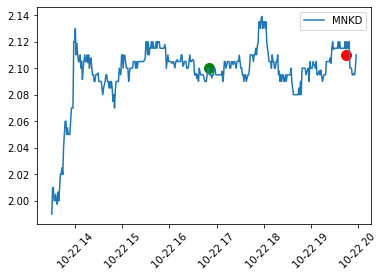

MRO analysis with profit $8.04


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3465.24,-3465.24,buy,2020-10-22 12:15:06.995505-04:00,4.31,804,4.61%,1.93%,"{'buy': {'avg': 4.1994, 'macd': [0.005893513741304979, 0.0052772263943534625, 0.00593082204680595, 0.006375310697054104, 0.007049764076056952], 'vwap': 4.31, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.006334932849159559, 0.00612339155819834, 0.006084877655919862, 0.0061429642641467105, 0.0063243242265287585]}, 'sell': None}",4.66,4.19
1,8.04,3473.28,sell,2020-10-22 14:35:38.577169-04:00,4.32,804,4.85%,,"{'buy': None, 'sell': {'avg': 4.2385, 'rsi': [65.6310322837746, 58.038267229461084, 58.038267229461084], 'vwap': 4.32, 'reasons': 'bail post whipsawed', 'movement': 0.002320185614849345, 'sell_macd': [0.007861126006504016, 0.007504186332349505, 0.007554568581938703, 0.006976235677957909, 0.006434986198518899], 'sell_macd_signal': [0.006752581862293953, 0.0069029027563050635, 0.007033235921431792, 0.007021835872737015, 0.006904465937893392]}}",4.66,4.19


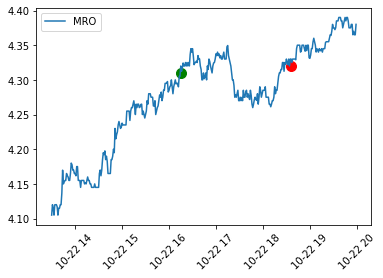

MUR analysis with profit $-12.12


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2702.76,-2702.76,buy,2020-10-22 12:28:27.734047-04:00,8.92,303,4.33%,2.04%,"{'buy': {'avg': 8.7241, 'macd': [0.02128926589733915, 0.020846240174179798, 0.020062146058609898, 0.02161236125514243, 0.022580622605644862], 'vwap': 8.92, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.019989001909869603, 0.020160449562731643, 0.020140788861907295, 0.020435103340554324, 0.02086420719357243]}, 'sell': None}",9.85,8.61
1,-12.12,2690.64,sell,2020-10-22 14:22:46.601088-04:00,8.88,303,3.86%,,"{'buy': None, 'sell': {'avg': 8.7443, 'rsi': [77.07606649398154, 78.66878481719526, 79.43803761481283], 'vwap': 8.885, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.003923766816143513, 'sell_macd': [0.014223245690226705, 0.01561534270304854, 0.01701677748313024, 0.018407287993802868, 0.01951148724895191], 'sell_macd_signal': [0.011139502707366218, 0.012034670706502684, 0.013031092061828195, 0.01410633124822313, 0.015187362448368885]}}",9.85,8.61


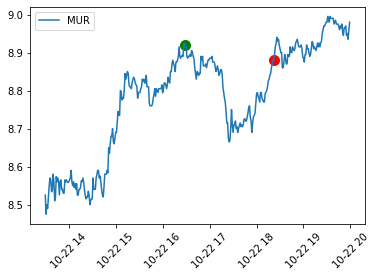

NBEV analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2211.30,-2211.30,buy,2020-10-22 12:24:25.082340-04:00,2.70,819,3.85%,2.43%,"{'buy': {'avg': 2.6631, 'macd': [-0.009860529652069072, -0.00836537566238782, -0.007417715121613266, -0.006271625351814247, -0.005302220257506818], 'vwap': 2.6996, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.00611480424507182, -0.00656491852853502, -0.006735477847150669, -0.0066427073480833845, -0.006374609929968071]}, 'sell': None}",3.04,2.59
1,0.00,2211.30,sell,2020-10-22 13:34:11.177043-04:00,2.70,819,3.85%,,"{'buy': None, 'sell': {'avg': 2.6659, 'rsi': [58.68517676510703, 53.494958782237454, 53.494958782237454], 'vwap': 2.705, 'reasons': 'bail post whipsawed', 'movement': 0.0018518518518518122, 'sell_macd': [0.0028095591147359045, 0.002859357230788895, 0.0028610264480928294, 0.002565430689522863, 0.0023017790505135416], 'sell_macd_signal': [0.0027391568241150097, 0.0027631969054497866, 0.0027827628139783954, 0.002739296389087289, 0.0026517929213725395]}}",3.04,2.59


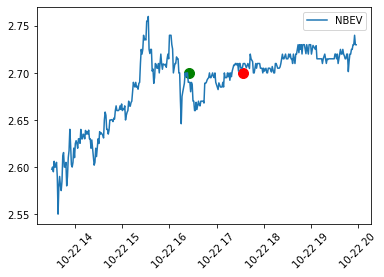

NGL analysis with profit $41.16


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2593.08,-2593.08,buy,2020-10-22 10:54:46.178471-04:00,3.78,686,2.72%,1.24%,"{'buy': {'avg': 3.7255, 'macd': [0.0007057801069532132, -0.00018173461482717812, 0.0023158733338046744, 0.005044017756991259, 0.007123971162541931], 'vwap': 3.784, 'macd_signal': [0.003974378999416022, 0.003143156276567382, 0.0029776996880148407, 0.0033909633018101245, 0.004137564873956486]}, 'sell': None}",4.19,3.64
1,41.16,2634.24,sell,2020-10-22 11:26:43.178576-04:00,3.84,686,4.35%,,"{'buy': None, 'sell': {'avg': 3.7585, 'rsi': [57.716524297603335, 60.799967910219934, 56.37286022857377], 'vwap': 3.8497, 'reasons': 'bail', 'movement': 0.01587301587301589, 'sell_macd': [0.011667259943457964, 0.010781838179581005, 0.009951875270331811, 0.009695386311562082, 0.009354026261720882], 'sell_macd_signal': [0.01014895867458945, 0.01027553457558776, 0.01021080271453657, 0.010107719433941672, 0.009956980799497514]}}",4.19,3.64


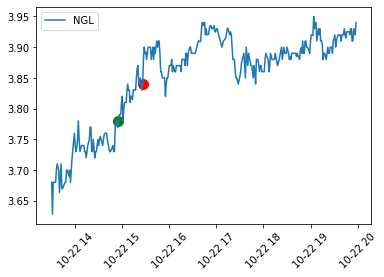

NTN analysis with profit $41.71


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1124.39,-1124.39,buy,2020-10-22 12:26:58.093381-04:00,2.29,491,11.17%,4.72%,"{'buy': {'avg': 2.1573, 'macd': [-0.005566000332543286, -0.006910692751967762, -0.0063059851859672555, -0.005760348372878976, 0.004313416633077605], 'vwap': 2.2653, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.0030660539948447474, -0.0038349817462693505, -0.004329182434208932, -0.004615415621942941, -0.0028296491709388317]}, 'sell': None}",2.86,2.10
1,-536.39,588.00,sell,2020-10-22 12:59:47.734795-04:00,2.40,245,16.5%,,"{'buy': None, 'sell': {'avg': 2.2151, 'rsi': [70.91981064477645, 68.2054842316935, 71.69391553829232], 'vwap': 2.3954, 'reasons': 'scale-out', 'movement': 0.0479912663755459, 'sell_macd': [0.01035813055897794, 0.013568363262841832, 0.017088435976725158, 0.01908994152031296, 0.021721115430636928], 'sell_macd_signal': [0.007940539812276102, 0.009066104502389248, 0.01067057079725643, 0.012354444941867736, 0.014227779039621575]}}",2.86,2.10
2,41.71,578.10,sell,2020-10-22 13:05:36.814181-04:00,2.35,246,14.08%,,"{'buy': None, 'sell': {'avg': 2.2444, 'rsi': [58.565446982038516, 56.975546368867704, 55.32507079793943], 'vwap': 2.3503, 'reasons': 'bail', 'movement': -0.02083333333333326, 'sell_macd': [0.02096430174390873, 0.020966754796353015, 0.020685981138564458, 0.019689456455371346, 0.0181533403846319], 'sell_macd_signal': [0.017426413087373766, 0.018134481429169617, 0.018644781371048587, 0.01885371638791314, 0.01871364118725689]}}",2.86,2.10


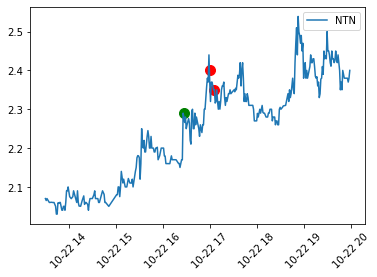

NYCB analysis with profit $44.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3884.16,-3884.16,buy,2020-10-22 12:15:43.755504-04:00,8.67,448,3.71%,2.22%,"{'buy': {'avg': 8.5452, 'macd': [-0.001074269851999432, -0.0014241396737517675, -0.0016820246945119521, -0.00026946139517036727, 0.001239178926480733], 'vwap': 8.675, 'reason': ['MACD zero-cross'], 'macd_signal': [0.0009304142908621704, 0.00045950349793938276, 3.119785944911572e-05, -2.893399147478088e-05, 0.00022468859211632186]}, 'sell': None}",9.30,8.47
1,44.80,3928.96,sell,2020-10-22 14:37:13.604819-04:00,8.77,448,4.9%,,"{'buy': None, 'sell': {'avg': 8.5898, 'rsi': [74.08766332178361, 78.93702143766326, 80.26295922137109], 'vwap': 8.7747, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.012110726643598664, 'sell_macd': [0.006929331302613306, 0.007342621903614344, 0.007829048061489985, 0.00888562626163214, 0.00983769205055296], 'sell_macd_signal': [0.0052554904653107715, 0.005672916752971486, 0.006104143014675186, 0.006660439664066577, 0.007295890141363853]}}",9.30,8.47


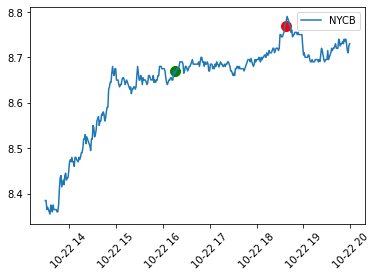

OPTT analysis with profit $-35.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-680.13,-680.13,buy,2020-10-22 10:11:59.332843-04:00,2.29,297,11.96%,7.07%,"{'buy': {'avg': 2.1899, 'macd': [0.02655185593868703, 0.032677390188452726, 0.03639423451304458, 0.04298385061335974, 0.049068776610890374], 'vwap': 2.2939, 'macd_signal': [0.019642966544032598, 0.022249851272916624, 0.025078727920942213, 0.02865975245942572, 0.03274155728971865]}, 'sell': None}",3.24,1.99
1,-35.64,644.49,sell,2020-10-22 15:45:13.702147-04:00,2.17,297,6.1%,,"{'buy': None, 'sell': {'liquidation': 1}}",3.24,1.99


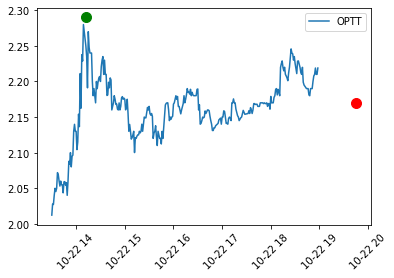

ORI analysis with profit $19.37


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2538.96,-2538.96,buy,2020-10-22 10:40:42.542079-04:00,17.04,149,3.84%,0.96%,"{'buy': {'avg': 16.5668, 'macd': [0.057829601683490495, 0.05973709559066265, 0.06254510824624404, 0.0652289345918291, 0.07137462264501337], 'vwap': 17.035, 'macd_signal': [0.06270749726172736, 0.06211341692751442, 0.06219975519126034, 0.0628055910713741, 0.06451939738610195]}, 'sell': None}",18.90,16.42
1,19.37,2558.33,sell,2020-10-22 14:00:42.965401-04:00,17.17,149,4.63%,,"{'buy': None, 'sell': {'avg': 16.8257, 'rsi': [72.66622067991783, 75.96915506565455, 79.89384409031636], 'vwap': 17.1796, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.008802816901408576, 'sell_macd': [0.008607974838607646, 0.01008607112430937, 0.012145807566096067, 0.014632020279616853, 0.01739748446834355], 'sell_macd_signal': [0.004835935140382174, 0.005885962337167613, 0.007137931382953304, 0.008636749162286014, 0.01038889622349752]}}",18.90,16.42


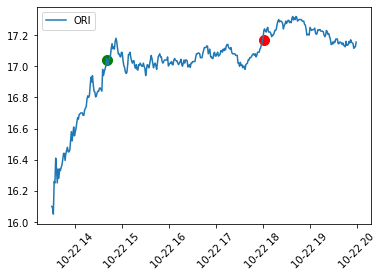

OVV analysis with profit $14.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3499.48,-3499.48,buy,2020-10-22 12:08:09.766538-04:00,9.83,356,3.53%,1.74%,"{'buy': {'avg': 9.6605, 'macd': [0.005888112305109772, 0.006591462475398657, 0.005870822723055724, 0.007233616960132139, 0.009415480058011738], 'vwap': 9.835, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.006820232783543611, 0.0067744787219146205, 0.006593747522142842, 0.006721721409740701, 0.007260473139394909]}, 'sell': None}",10.62,9.57
1,14.24,3513.72,sell,2020-10-22 14:31:40.552330-04:00,9.87,356,3.95%,,"{'buy': None, 'sell': {'avg': 9.7148, 'rsi': [61.03381999713928, 59.783825269612976, 59.78382526961299], 'vwap': 9.87, 'reasons': 'bail post whipsawed', 'movement': 0.004069175991861561, 'sell_macd': [0.013237073127019272, 0.012796291653375036, 0.012452873730360636, 0.011857315949695746, 0.011239253835546137], 'sell_macd_signal': [0.010884544954474646, 0.011266894294254724, 0.011504090181475907, 0.011574735335119875, 0.011507639035205127]}}",10.62,9.57


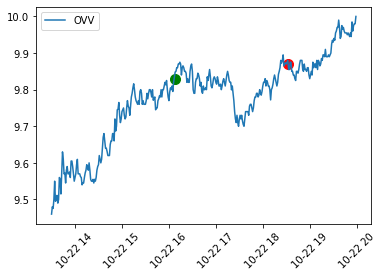

PDCE analysis with profit $27.74


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1716.00,-1716.00,buy,2020-10-22 12:31:06.140028-04:00,13.20,130,2.13%,0.71%,"{'buy': {'avg': 13.0164, 'macd': [0.014495480516732329, 0.012949679774559186, 0.014781890819584476, 0.016048929207343576, 0.01925189171390862], 'vwap': 13.2, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.016525428384002873, 0.015810278662114135, 0.015604601093608204, 0.015693466716355277, 0.016405151715865946]}, 'sell': None}",14.26,12.85
1,-3483.46,-1767.46,buy,2020-10-22 12:31:22.820442-04:00,13.19,134,2.05%,0.71%,"{'buy': {'avg': 13.0164, 'macd': [0.014495480516732329, 0.012949679774559186, 0.014781890819584476, 0.016048929207343576, 0.01925189171390862], 'vwap': 13.2, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.016525428384002873, 0.015810278662114135, 0.015604601093608204, 0.015693466716355277, 0.016405151715865946]}, 'sell': None}",14.26,12.85
2,27.74,3511.20,sell,2020-10-22 15:30:09.743600-04:00,13.30,264,2.9%,,"{'buy': None, 'sell': {'avg': 13.0849, 'rsi': [78.81849660135704, 74.53193982626965, 79.36596827673496], 'vwap': 13.3123, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.010614101592115283, 'sell_macd': [0.013872092464517038, 0.016130106589576698, 0.018978817510536317, 0.020432633585174997, 0.022458559960410795], 'sell_macd_signal': [0.008889779579421149, 0.010337844981452259, 0.01206603948726907, 0.013739358306850255, 0.015483198637562364]}}",14.26,12.85


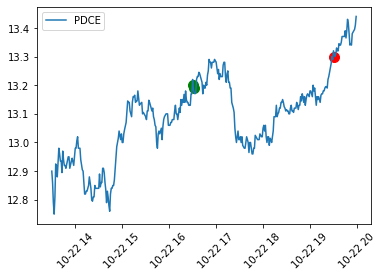

PE analysis with profit $13.84


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3501.52,-3501.52,buy,2020-10-22 12:55:16.302707-04:00,10.12,346,3.74%,0.7%,"{'buy': {'avg': 9.8235, 'macd': [0.005155434356769462, 0.005573618492446641, 0.007832040610228574, 0.009512205624329084, 0.010720173021422141], 'vwap': 10.12, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.009714804643480776, 0.00888656741327395, 0.008675662052664875, 0.008842970766997717, 0.009218411217882602]}, 'sell': None}",10.93,9.85
1,13.84,3515.36,sell,2020-10-22 14:05:39.242582-04:00,10.16,346,4.15%,,"{'buy': None, 'sell': {'avg': 9.8778, 'rsi': [63.5748825541653, 61.61783041337047, 57.786431388610424], 'vwap': 10.165, 'reasons': 'bail post whipsawed', 'movement': 0.004446640316205527, 'sell_macd': [0.012442989086077105, 0.01386834706286244, 0.01387942669330755, 0.013448067617117587, 0.01241781291336963], 'sell_macd_signal': [0.011450145811280758, 0.011933786061597094, 0.012322914187939186, 0.012547944873774867, 0.01252191848169382]}}",10.93,9.85


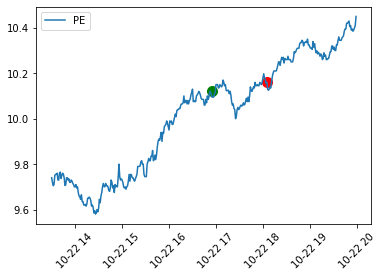

PLAY analysis with profit $8.54


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2475.38,-2475.38,buy,2020-10-22 10:32:46.358569-04:00,20.29,122,4.64%,2.46%,"{'buy': {'avg': 19.8662, 'macd': [0.03344760801404334, 0.02954261461393415, 0.02853964127066888, 0.035046831485825436, 0.051272728873929196], 'vwap': 20.2898, 'macd_signal': [0.05632037873883884, 0.050964825913857904, 0.0464797889852201, 0.04419319748534117, 0.045609103763058774]}, 'sell': None}",22.57,19.54
1,8.54,2483.92,sell,2020-10-22 13:09:07.417288-04:00,20.36,122,5.0%,,"{'buy': None, 'sell': {'avg': 19.9763, 'rsi': [67.34105327598346, 61.13252625710069, 62.17010233430075], 'vwap': 20.3592, 'reasons': 'bail post whipsawed', 'movement': 0.0034499753573188903, 'sell_macd': [0.04075059359511357, 0.03923054290905981, 0.039282054804221644, 0.03693151790689342, 0.03509822268940255], 'sell_macd_signal': [0.036163978436818726, 0.03677729133126694, 0.03727824402585788, 0.03720889880206499, 0.0367867635795325]}}",22.57,19.54


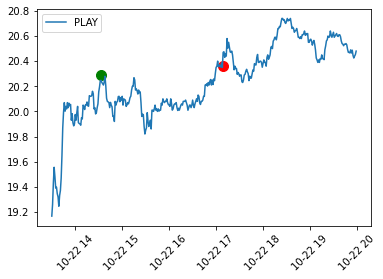

PLTR analysis with profit $45.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3963.25,-3963.25,buy,2020-10-22 12:50:08.767525-04:00,9.55,415,3.75%,3.36%,"{'buy': {'avg': 9.5139, 'macd': [-0.03467911278248614, -0.03298284854075817, -0.03167685406600462, -0.030292649231755675, -0.028065222091170128], 'vwap': 9.555, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.030336534458895083, -0.0308657972752677, -0.031028008633415087, -0.030880936753083205, -0.03031779382070059]}, 'sell': None}",10.23,9.33
1,45.65,4008.90,sell,2020-10-22 15:45:05.779767-04:00,9.66,415,4.94%,,"{'buy': None, 'sell': {'liquidation': 1}}",10.23,9.33


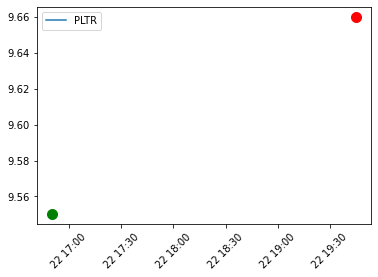

RF analysis with profit $88.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3703.92,-3703.92,buy,2020-10-22 12:39:30.057491-04:00,13.42,276,5.25%,3.04%,"{'buy': {'avg': 13.1371, 'macd': [0.00979074036252392, 0.010811101773882115, 0.01068960599333657, 0.011669179316344369, 0.013500250389171242], 'vwap': 13.4103, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.010840661656994034, 0.010834749680371649, 0.010805720942964633, 0.010978412617640581, 0.011482780171946714]}, 'sell': None}",14.43,13.08
1,88.32,3792.24,sell,2020-10-22 15:36:07.589038-04:00,13.74,276,7.76%,,"{'buy': None, 'sell': {'avg': 13.3873, 'rsi': [66.65546245944866, 67.73832486572076, 59.425206699767315], 'vwap': 13.7422, 'reasons': 'bail', 'movement': 0.02384500745156485, 'sell_macd': [0.015494807890551243, 0.015207769031066576, 0.015306079412882312, 0.015443644912830123, 0.01442559666716825], 'sell_macd_signal': [0.01435744796083675, 0.014527512174882715, 0.014683225622482634, 0.014835309480552132, 0.014753366917875356]}}",14.43,13.08


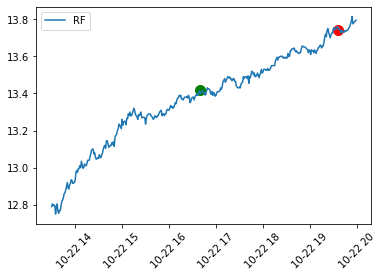

RRC analysis with profit $-93.28


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3816.00,-3816.00,buy,2020-10-22 12:16:38.995046-04:00,9.00,424,4.17%,2.62%,"{'buy': {'avg': 8.8662, 'macd': [-0.00012424997615134714, 9.2790173829016e-05, 0.0010594992352235266, 0.0022036787079944276, 0.0030750024691901245], 'vwap': 9.0025, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0015721430133883835, 0.00127627244547651, 0.0012329178034259133, 0.001427069984339616, 0.0017566564813097179]}, 'sell': None}",9.67,8.78
1,-93.28,3722.72,sell,2020-10-22 13:29:52.618301-04:00,8.78,424,1.62%,,"{'buy': None, 'sell': {'avg': 8.8753, 'rsi': [30.216985980842843, 27.011735315598706, 24.88011800457606], 'vwap': 8.7807, 'reasons': 'stopped', 'movement': -0.024444444444444515, 'sell_macd': [-0.011670206630856939, -0.015122728043250433, -0.01631790410429268, -0.01807625033232263, -0.019954490895303323], 'sell_macd_signal': [-0.006037853457895907, -0.007854828374966812, -0.009547443520831986, -0.011253204883130115, -0.012993462085564757]}}",9.67,8.78


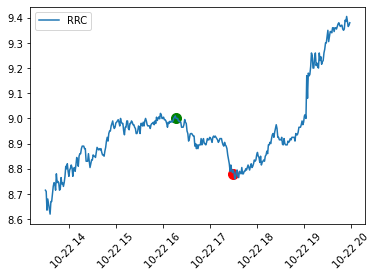

SABR analysis with profit $62.56


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2897.31,-2897.31,buy,2020-10-22 12:12:11.376487-04:00,7.41,391,6.01%,3.18%,"{'buy': {'avg': 7.2126, 'macd': [-0.009562827331660806, -0.009569810470406281, -0.008469072924176757, -0.0037209842720118402, 0.0004402929827840296], 'vwap': 7.4238, 'reason': ['MACD histogram reversal', 'MACD zero-cross'], 'macd_signal': [-0.004590436955063637, -0.005586311658132166, -0.006162863911341084, -0.005674487983475236, -0.004451531790223383]}, 'sell': None}",8.14,7.19
1,62.56,2959.87,sell,2020-10-22 12:45:34.315581-04:00,7.57,391,8.3%,,"{'buy': None, 'sell': {'avg': 7.2739, 'rsi': [65.53172296542246, 69.74267190542457, 79.09432213562842], 'vwap': 7.597, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.026990553306342802, 'sell_macd': [0.014903732046889218, 0.015470622388106925, 0.015971178207392356, 0.017452505102842686, 0.022120389630429393], 'sell_macd_signal': [0.009916033972190505, 0.011026951655373788, 0.012015796965777502, 0.013103138593190539, 0.01490658880063831]}}",8.14,7.19


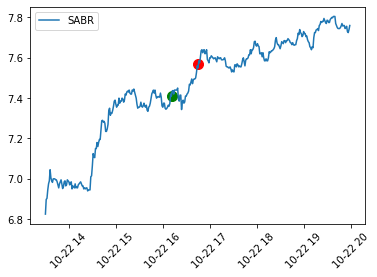

SAVE analysis with profit $82.33


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2908.71,-2908.71,buy,2020-10-22 10:49:22.255422-04:00,17.01,171,2.04%,1.55%,"{'buy': {'avg': 16.9287, 'macd': [-0.013052704621852484, -0.013001099891038592, -0.010977750316857993, -0.00448107756994176, 0.0016172395687554797], 'vwap': 17.01, 'macd_signal': [-0.022057398702538537, -0.020246138940238547, -0.018392461215562435, -0.0156101844864383, -0.012164699675399545]}, 'sell': None}",18.63,16.47
1,80.37,2989.08,sell,2020-10-22 11:20:05.127384-04:00,17.48,171,4.86%,,"{'buy': None, 'sell': {'avg': 17.0073, 'rsi': [76.21025251384536, 76.21025251384535, 79.24472111623729], 'vwap': 17.4855, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.028218694885361367, 'sell_macd': [0.04542579431616289, 0.04905122412393581, 0.051239205479031824, 0.05227868178847217, 0.054773355772599785], 'sell_macd_signal': [0.04316510797907366, 0.044342331208046086, 0.04572170606224323, 0.04703310120748902, 0.04858115212051117]}}",18.63,16.47
2,-3359.43,-3439.80,buy,2020-10-22 12:13:42.408029-04:00,17.55,196,5.28%,2.6%,"{'buy': {'avg': 17.1037, 'macd': [0.030545173613170107, 0.031763404354165914, 0.03235588252042376, 0.03604109039973835, 0.03891649725219892], 'vwap': 17.55, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.032540352649565694, 0.03238496299048574, 0.032379146896473344, 0.033111535597126346, 0.03427252792814086]}, 'sell': None}",18.98,17.07
3,82.33,3441.76,sell,2020-10-22 13:21:09.341002-04:00,17.56,196,5.34%,,"{'buy': None, 'sell': {'avg': 17.1681, 'rsi': [64.73091359766121, 51.44787867275321, 50.154786633242686], 'vwap': 17.5699, 'reasons': 'bail post whipsawed', 'movement': 0.0009344729344729834, 'sell_macd': [0.0185620131891433, 0.01870220846430115, 0.018568565711643004, 0.015729771804224413, 0.013204350943844645], 'sell_macd_signal': [0.013343824112846275, 0.01441550098313725, 0.0152461139288384, 0.015342845503915603, 0.01491514659190141]}}",18.98,17.07


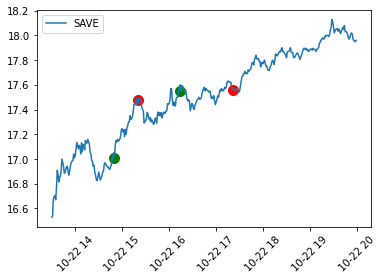

SBGI analysis with profit $-57.75


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1535.38,-1535.38,buy,2020-10-22 09:50:23.904477-04:00,19.94,77,1.89%,0.1%,"{'buy': {'avg': 19.59, 'macd': [0.12349089416997572, 0.1278936677629936, 0.1334754001476881, 0.13752404631635073, 0.14351630133377924], 'vwap': 19.9294, 'macd_signal': [0.1110061862011943, 0.11438368251355416, 0.11820202604038095, 0.12206643009557491, 0.12635640434321577]}, 'sell': None}",23.55,18.75
1,-364.79,1170.59,sell,2020-10-22 15:45:13.652588-04:00,19.19,61,-1.94%,,"{'buy': None, 'sell': {'liquidation': 1}}",23.55,18.75
2,-57.75,307.04,sell,2020-10-22 15:45:13.812294-04:00,19.19,16,-1.94%,,"{'buy': None, 'sell': {'liquidation': 1}}",23.55,18.75


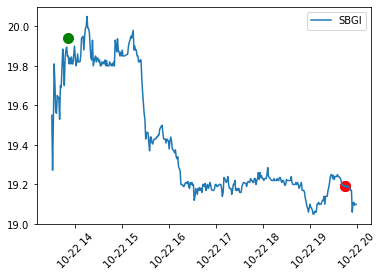

SIEN analysis with profit $114.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3640.80,-3640.80,buy,2020-10-22 12:43:44.878192-04:00,4.44,820,3.02%,0.65%,"{'buy': {'avg': 4.3382, 'macd': [-0.0010277856133695806, -0.0019109226251208256, -0.00018789979814304303, 0.0011641881694108847, 0.0014125284497517043], 'vwap': 4.4405, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0005687151939891296, 7.278763016713857e-05, 2.0650144505102248e-05, 0.00024935774948625877, 0.00048199188953934786]}, 'sell': None}",4.78,4.33
1,114.80,3755.60,sell,2020-10-22 13:13:15.521571-04:00,4.58,820,6.26%,,"{'buy': None, 'sell': {'avg': 4.3636, 'rsi': [70.91197197379721, 74.50733925129292, 79.86714476632665], 'vwap': 4.5893, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.03378378378378366, 'sell_macd': [0.008451462947440369, 0.010011565359247854, 0.011616689766380084, 0.013755530995751108, 0.017285075707004438], 'sell_macd_signal': [0.007059678829836601, 0.007650056135718852, 0.008443382861851098, 0.0095058124886311, 0.011061665132305767]}}",4.78,4.33


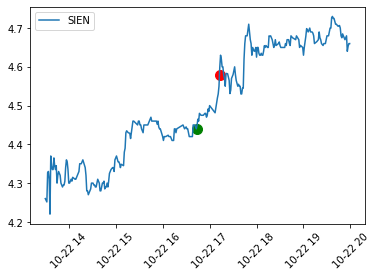

SKT analysis with profit $55.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3407.04,-3407.04,buy,2020-10-22 12:25:48.662367-04:00,6.76,504,5.62%,3.85%,"{'buy': {'avg': 6.6461, 'macd': [-0.0014892684760567931, -0.0015359170207132067, -0.0007572409001941338, -5.876541089655518e-05, 0.0012070916295607859], 'vwap': 6.76, 'reason': ['MACD histogram reversal'], 'macd_signal': [-0.0004402748957263664, -0.0006594033207237345, -0.0006789708366178144, -0.0005549297514735625, -0.0002025254752666928]}, 'sell': None}",7.32,6.57
1,55.44,3462.48,sell,2020-10-22 13:52:13.533427-04:00,6.87,504,7.34%,,"{'buy': None, 'sell': {'avg': 6.6763, 'rsi': [75.19073416917533, 77.71886539793371, 81.72902837311614], 'vwap': 6.8721, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.017751479289940846, 'sell_macd': [0.006495993869413574, 0.008044625394695082, 0.009146875604074012, 0.01040646179834237, 0.011881380108183848], 'sell_macd_signal': [0.0050336056625267574, 0.005635809608960422, 0.00633802280798314, 0.007151710606054986, 0.008097644506480758]}}",7.32,6.57


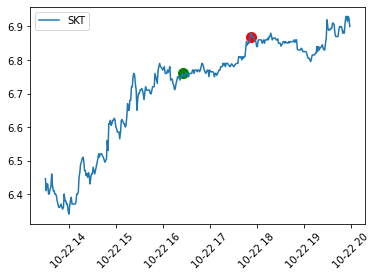

SONO analysis with profit $40.12


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1813.66,-1813.66,buy,2020-10-22 10:20:28.114682-04:00,15.37,118,1.86%,0.6%,"{'buy': {'avg': 15.1798, 'macd': [0.058271718176740706, 0.06063956923362923, 0.06978088195075038, 0.07878811120831664, 0.08620758585503197], 'vwap': 15.3773, 'macd_signal': [0.041844513093915334, 0.045603524321858116, 0.05043899584763657, 0.05610881891977258, 0.06212857230682446]}, 'sell': None}",17.74,14.59
1,40.12,1853.78,sell,2020-10-22 15:45:06.801217-04:00,15.71,118,4.11%,,"{'buy': {'reason': 'stopped', 'close_5m': [15.74, 15.84, 15.84, 15.885, 15.71]}, 'sell': {'liquidation': 1}}",13.19,13.92


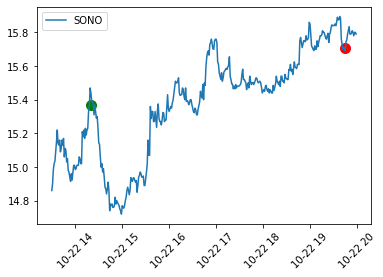

SRG analysis with profit $65.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2605.50,-2605.50,buy,2020-10-22 12:55:05.880552-04:00,13.50,193,3.45%,2.03%,"{'buy': {'avg': 13.3152, 'macd': [-0.011017854738666344, -0.010615525883766352, -0.009381615517291664, -0.005914801235668676, -0.0007380686647593393], 'vwap': 13.4762, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.007277143644793438, -0.00794482009258802, -0.00823217917752875, -0.007768703589156735, -0.006362576604277256]}, 'sell': None}",14.58,13.14
1,-2673.00,-67.50,buy,2020-10-22 12:55:06.079048-04:00,13.50,5,3.45%,2.03%,"{'buy': {'avg': 13.3152, 'macd': [-0.011017854738666344, -0.010615525883766352, -0.009381615517291664, -0.005914801235668676, -0.0007380686647593393], 'vwap': 13.4762, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.007277143644793438, -0.00794482009258802, -0.00823217917752875, -0.007768703589156735, -0.006362576604277256]}, 'sell': None}",14.58,13.14
2,-3510.00,-837.00,buy,2020-10-22 12:55:06.181072-04:00,13.50,62,3.45%,2.03%,"{'buy': {'avg': 13.3152, 'macd': [-0.011017854738666344, -0.010615525883766352, -0.009381615517291664, -0.005914801235668676, -0.0007380686647593393], 'vwap': 13.4762, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.007277143644793438, -0.00794482009258802, -0.00823217917752875, -0.007768703589156735, -0.006362576604277256]}, 'sell': None}",14.58,13.14
3,65.00,3575.00,sell,2020-10-22 15:38:18.743730-04:00,13.75,260,5.36%,,"{'buy': None, 'sell': {'avg': 13.4697, 'rsi': [58.26752946928517, 55.45154260570519, 55.01106342407082], 'vwap': 13.76, 'reasons': 'bail', 'movement': 0.019259259259259243, 'sell_macd': [0.01758363811522834, 0.017414897832603415, 0.016797504134030916, 0.015422944055480059, 0.01404766420134429], 'sell_macd_signal': [0.01327079366366194, 0.014099614497450235, 0.014639192424766372, 0.014795942750909109, 0.014646287040996145]}}",14.58,13.14


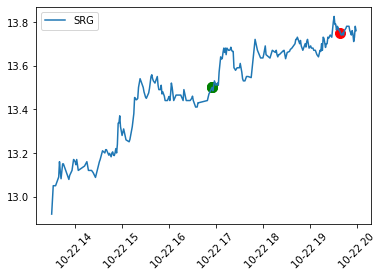

SRNE analysis with profit $21.10


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3473.06,-3473.06,buy,2020-10-22 12:54:28.448877-04:00,8.23,422,1.73%,-0.19%,"{'buy': {'avg': 8.0745, 'macd': [0.000828212536699624, 0.0007119178665853099, 0.001817249189240755, 0.004250004508254079, 0.0060995990800361], 'vwap': 8.2399, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0029088785087117218, 0.0024694863802864394, 0.0023390389420773023, 0.0027212320553126577, 0.003396905460257346]}, 'sell': None}",8.91,8.02
1,21.10,3494.16,sell,2020-10-22 15:45:27.573455-04:00,8.28,422,2.35%,,"{'buy': None, 'sell': {'liquidation': 1}}",8.91,8.02


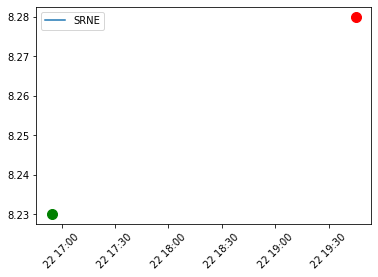

SWN analysis with profit $39.16


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2927.21,-2927.21,buy,2020-10-22 10:51:43.234069-04:00,2.99,979,2.93%,1.05%,"{'buy': {'avg': 2.9354, 'macd': [0.004692607410328176, 0.005189007928350531, 0.005518791719639982, 0.0057142771205689336, 0.006998896427615087], 'vwap': 2.995, 'macd_signal': [0.006796799124829557, 0.006475240885533752, 0.006283951052354998, 0.006170016265997785, 0.006335792298321245]}, 'sell': None}",3.28,2.90
1,39.16,2966.37,sell,2020-10-22 11:45:44.374717-04:00,3.03,979,4.3%,,"{'buy': None, 'sell': {'avg': 2.9575, 'rsi': [58.1007729306957, 58.1007729306957, 52.161037606134165], 'vwap': 3.0324, 'reasons': 'bail', 'movement': 0.014381270903009934, 'sell_macd': [0.00506383311228209, 0.004531241165040889, 0.004317127424787515, 0.004094218959333595, 0.003472547181585739], 'sell_macd_signal': [0.004404771946558028, 0.0044300657902546, 0.004407478117161183, 0.004344826285595666, 0.004170370464793681]}}",3.28,2.90
2,-3091.22,-3130.38,buy,2020-10-22 12:11:07.109198-04:00,3.06,1023,5.34%,2.35%,"{'buy': {'avg': 2.9733, 'macd': [0.0030549768723000525, 0.0029553857507105263, 0.0030191774845000907, 0.0036569724043125085, 0.0041149943796150446], 'vwap': 3.06, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0037826062820250847, 0.003617162175762173, 0.003497565237509757, 0.003529446670870307, 0.0036465562126192547]}, 'sell': None}",3.33,2.97
3,39.16,3130.38,sell,2020-10-22 15:04:23.416050-04:00,3.06,1023,5.34%,,"{'buy': None, 'sell': {'avg': 3.0064, 'rsi': [63.50526215541479, 63.505262155414776, 57.704355222324565], 'vwap': 3.061, 'reasons': 'bail post whipsawed', 'movement': 0.000326797385620879, 'sell_macd': [0.0038944820964181837, 0.003920137491963516, 0.003889217832752756, 0.003814615269305932, 0.003499150735850165], 'sell_macd_signal': [0.0036428816006979408, 0.003698332778951056, 0.003736509789711396, 0.0037521308856303033, 0.0037015348556742756]}}",3.33,2.97


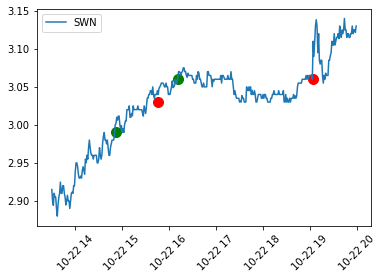

TAOP analysis with profit $14.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1279.08,-1279.08,buy,2020-10-22 10:06:59.283627-04:00,3.42,374,6.54%,3.52%,"{'buy': {'avg': 3.323, 'macd': [0.016105959402998415, 0.01533672530162411, 0.020941037896825332, 0.024295515993956407, 0.03143312115844443], 'vwap': 3.4068, 'macd_signal': [0.005953698595910777, 0.007830303937053444, 0.010452450729007821, 0.013221063781997538, 0.016863475257286917]}, 'sell': None}",4.16,3.17
1,14.96,1294.04,sell,2020-10-22 13:20:51.802502-04:00,3.46,374,7.79%,,"{'buy': None, 'sell': {'avg': 3.3747, 'rsi': [57.47715685655801, 60.90251265307125, 52.472870466684306], 'vwap': 3.46, 'reasons': 'bail', 'movement': 0.01169590643274855, 'sell_macd': [0.020230732975215382, 0.020487624190745013, 0.01903990794062871, 0.018786623746503306, 0.016267355234892644], 'sell_macd_signal': [0.014295008164059661, 0.015533531369396732, 0.016234806683643126, 0.01674517009621516, 0.01664960712395066]}}",4.16,3.17


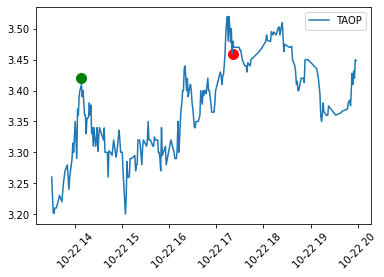

TBPH analysis with profit $-8.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3293.92,-3293.92,buy,2020-10-22 12:54:15.822190-04:00,19.04,173,2.59%,0.9%,"{'buy': {'avg': 18.7276, 'macd': [0.0017374818817259552, 0.0024698150623514437, 0.005408596727370707, 0.012435749351219272, 0.018597356115190422], 'vwap': 19.05, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01213313867584431, 0.010200473953145736, 0.00924209850799073, 0.009880828676636439, 0.011624134164347235]}, 'sell': None}",20.67,18.51
1,-8.65,3285.27,sell,2020-10-22 15:45:13.970298-04:00,18.99,173,2.32%,,"{'buy': None, 'sell': {'liquidation': 1}}",20.67,18.51


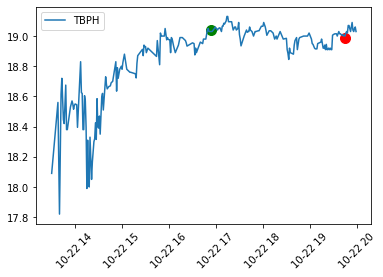

TC analysis with profit $-99.42


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1978.92,-1978.92,buy,2020-10-22 12:15:22.654484-04:00,4.78,414,19.5%,29.53%,"{'buy': {'avg': 5.1811, 'macd': [-0.04018102208800034, -0.038757242892262234, -0.039154484344122054, -0.03427306970561794, -0.03085574405202518], 'vwap': 4.78, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.037427650612019525, -0.03769356906806807, -0.037985752123278864, -0.03724321563974668, -0.03596572132220238]}, 'sell': None}",5.46,4.55
1,-33.12,1945.80,sell,2020-10-22 12:17:56.753702-04:00,4.70,414,17.5%,,"{'buy': None, 'sell': {'avg': 5.1801, 'rsi': [46.194434648570834, 45.12338496285858, 44.63619514652909], 'vwap': 4.7108, 'reasons': 'below cost & macd negative & RSI trending down and too far from VWAP', 'movement': -0.011820083682008506, 'sell_macd': [-0.023530662188142593, -0.020255118575115638, -0.019647485648405016, -0.019786375762027575, -0.020676596944564807], 'sell_macd_signal': [-0.023376216654244126, -0.022751997038418428, -0.022131094760415745, -0.021662150960738112, -0.021465040157503452]}}",5.46,4.55
2,-872.92,-839.80,buy,2020-10-22 12:31:44.649465-04:00,4.94,170,23.5%,29.07%,"{'buy': {'avg': 5.1626, 'macd': [-0.05584940593637633, -0.0508484601807071, -0.03837366267776776, -0.02178088785150134, 0.0010320370163885428], 'vwap': 4.95, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.05512943427458243, -0.054273239455807365, -0.05109332410019944, -0.045230836850459824, -0.03597826207709015]}, 'sell': None}",6.60,4.40
3,-99.42,773.50,sell,2020-10-22 12:44:13.304469-04:00,4.55,170,13.75%,,"{'buy': None, 'sell': {'avg': 5.1505, 'rsi': [49.40281795844665, 44.289408574920564, 35.147869566130865], 'vwap': 4.55, 'reasons': 'below cost & macd negative & RSI trending down and too far from VWAP', 'movement': -0.07894736842105274, 'sell_macd': [0.015927594637634712, 0.013396874174081752, 0.010991158563857795, 0.005856949535581357, -0.005492524376524699], 'sell_macd_signal': [0.008146073616972664, 0.009196233728394482, 0.009555218695487144, 0.008815564863505987, 0.005953947015499849]}}",6.60,4.40


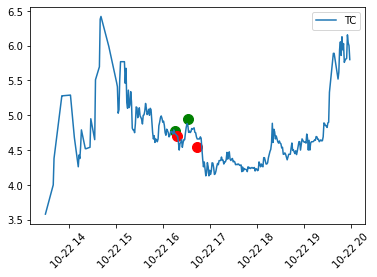

TECS analysis with profit $-102.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3194.51,-3194.51,buy,2020-10-22 13:06:33.809066-04:00,12.43,257,2.98%,2.87%,"{'buy': {'avg': 12.4169, 'macd': [-0.03214553191389946, -0.031124298192217736, -0.02957063304625862, -0.027218665959868105, -0.025065772476684955], 'vwap': 12.4317, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.02626264326088438, -0.02723497424715105, -0.027702106006972566, -0.027605417997551673, -0.02709748889337833]}, 'sell': None}",13.12,12.21
1,-5096.30,-1901.79,buy,2020-10-22 13:06:33.944202-04:00,12.43,153,2.98%,2.87%,"{'buy': {'avg': 12.4169, 'macd': [-0.03214553191389946, -0.031124298192217736, -0.02957063304625862, -0.027218665959868105, -0.025065772476684955], 'vwap': 12.4317, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.02626264326088438, -0.02723497424715105, -0.027702106006972566, -0.027605417997551673, -0.02709748889337833]}, 'sell': None}",13.12,12.21
2,-1016.00,4080.30,sell,2020-10-22 15:33:23.584687-04:00,12.18,335,0.91%,,"{'buy': None, 'sell': {'avg': 12.3871, 'rsi': [33.51365056655209, 31.226085458754294, 29.08788437611754], 'vwap': 12.2, 'reasons': 'stopped', 'movement': -0.018503620273531814, 'sell_macd': [-0.012230538514803158, -0.013542006224721348, -0.013868578385375585, -0.014462419310751429, -0.015256809391424042], 'sell_macd_signal': [-0.005522182646734267, -0.007126147362331683, -0.008474633566940464, -0.009672190715702658, -0.010789114450846935]}}",13.12,12.21
3,-102.50,913.50,sell,2020-10-22 15:33:23.757329-04:00,12.18,75,0.91%,,"{'buy': None, 'sell': {'avg': 12.3871, 'rsi': [33.51365056655209, 31.226085458754294, 29.08788437611754], 'vwap': 12.2, 'reasons': 'stopped', 'movement': -0.018503620273531814, 'sell_macd': [-0.012230538514803158, -0.013542006224721348, -0.013868578385375585, -0.014462419310751429, -0.015256809391424042], 'sell_macd_signal': [-0.005522182646734267, -0.007126147362331683, -0.008474633566940464, -0.009672190715702658, -0.010789114450846935]}}",13.12,12.21


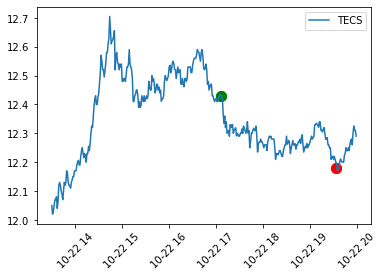

TEN analysis with profit $37.40


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3145.00,-3145.00,buy,2020-10-22 12:19:52.446796-04:00,9.25,340,2.44%,0.95%,"{'buy': {'avg': 9.1154, 'macd': [0.0033872237311527442, 0.004990049981246969, 0.0069866796645836615, 0.00847137038896939, 0.011133491379425209], 'vwap': 9.2468, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.008241360424127136, 0.007591098335551103, 0.007470214601357614, 0.007670445758879969, 0.008363054882989017]}, 'sell': None}",10.07,8.98
1,37.40,3182.40,sell,2020-10-22 15:45:41.546563-04:00,9.36,340,3.65%,,"{'buy': None, 'sell': {'liquidation': 1}}",10.07,8.98


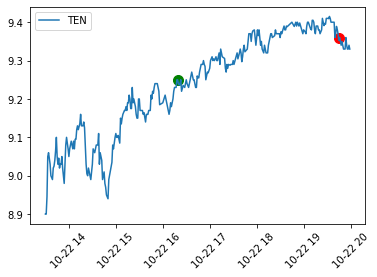

TRGP analysis with profit $-91.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3672.13,-3672.13,buy,2020-10-22 12:31:11.217280-04:00,17.57,209,5.84%,2.92%,"{'buy': {'avg': 17.0847, 'macd': [0.029559271545469556, 0.03108761965997786, 0.03073418733191602, 0.032899057304721424, 0.033821402071968265], 'vwap': 17.575, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.03332103170326668, 0.03287434929460892, 0.03244631690207034, 0.032536864982600555, 0.0327937724004741]}, 'sell': None}",18.91,17.13
1,-91.96,3580.17,sell,2020-10-22 13:23:55.513593-04:00,17.13,209,3.19%,,"{'buy': None, 'sell': {'avg': 17.1742, 'rsi': [30.63293517853749, 19.05430806787357, 13.004527110915598], 'vwap': 17.1353, 'reasons': 'stopped', 'movement': -0.025611838360842305, 'sell_macd': [-0.006943623240097452, -0.010039972655153662, -0.013361284242794369, -0.023048523346894, -0.037814572994932405], 'sell_macd_signal': [-0.005079971407448373, -0.0060719716569894305, -0.007529834174150418, -0.010633572008699134, -0.01606977220594579]}}",18.91,17.13


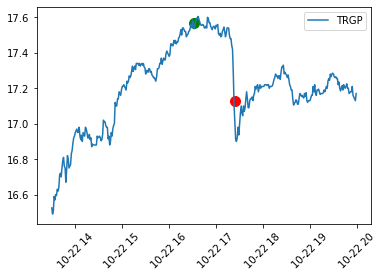

UMPQ analysis with profit $-93.48


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3303.78,-3303.78,buy,2020-10-22 10:55:43.252395-04:00,13.43,246,1.86%,0.49%,"{'buy': {'avg': 13.2492, 'macd': [0.0016900701955488984, 0.004233137977788459, 0.007772770707717314, 0.010457408650449196, 0.014037026313268086], 'vwap': 13.4191, 'macd_signal': [0.0024700171245271214, 0.002822641295179389, 0.003812667177686974, 0.005141615472239418, 0.006920697640445152]}, 'sell': None}",14.57,13.05
1,-93.48,3210.30,sell,2020-10-22 15:39:59.578540-04:00,13.05,246,-1.02%,,"{'buy': None, 'sell': {'avg': 13.2457, 'rsi': [32.218547332969635, 31.128023744902922, 27.166936157682308], 'vwap': 13.05, 'reasons': 'stopped', 'movement': -0.028294862248696873, 'sell_macd': [-0.0008335995658281803, -0.0016582213857549988, -0.0040974303183496374, -0.006204639482472629, -0.008805001954742764], 'sell_macd_signal': [-0.0025704249398159303, -0.002387984229003744, -0.0027298734468729226, -0.003424826653992864, -0.004500861714142844]}}",14.57,13.05


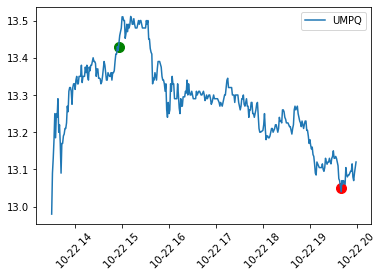

UNM analysis with profit $2.11


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-4103.95,-4103.95,buy,2020-10-22 13:07:25.896634-04:00,19.45,211,4.68%,2.47%,"{'buy': {'avg': 19.0384, 'macd': [0.012501913531703934, 0.012462339329321281, 0.013087033736809417, 0.013826187090401731, 0.014646592856433216], 'vwap': 19.45, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.013262846084755444, 0.013102744733668611, 0.013099602534296772, 0.013244919445517764, 0.013525254127700854]}, 'sell': None}",20.78,19.01
1,2.11,4106.06,sell,2020-10-22 14:32:15.611369-04:00,19.46,211,4.74%,,"{'buy': None, 'sell': {'avg': 19.1401, 'rsi': [63.92545206726231, 68.19487413070591, 65.79878640079174], 'vwap': 19.455, 'reasons': 'bail post whipsawed', 'movement': 0.00025706940874030876, 'sell_macd': [0.014808955708680571, 0.013888959334874329, 0.012991702948340844, 0.012851091440023055, 0.012366834531725601], 'sell_macd_signal': [0.017794695646049446, 0.01701354838381442, 0.016209179296719705, 0.015537561725380376, 0.01490341628664942]}}",20.78,19.01


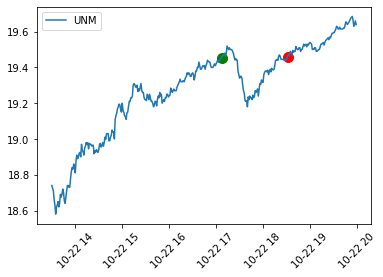

UONE analysis with profit $71.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1000.98,-1000.98,buy,2020-10-22 09:46:43.972392-04:00,6.03,166,5.42%,4.62%,"{'buy': {'avg': 5.9842, 'macd': [0.08002702690900687, 0.08670189554141583, 0.09296167130137789, 0.09837817172526364, 0.11585972423143964], 'vwap': 5.9812, 'macd_signal': [0.08127821495266382, 0.08236295107041422, 0.08448269511660696, 0.08726179043833829, 0.09298137719695856]}, 'sell': None}",7.67,5.43
1,18.26,1019.24,sell,2020-10-22 10:00:05.766630-04:00,6.14,166,7.34%,,"{'buy': None, 'sell': {'avg': 6.0239, 'rsi': [66.90064544976164, 60.26142193331329, 60.407719697263374], 'vwap': 6.1147, 'reasons': 'bail', 'movement': 0.013913764510779412, 'sell_macd': [0.08993990062301993, 0.08868329640843342, 0.09241213343072463, 0.08825782288405914, 0.08411864813491654], 'sell_macd_signal': [0.08198838741758838, 0.08332736921575738, 0.08514432205875083, 0.0857670222238125, 0.0854373474060333]}}",7.67,5.43
2,-1856.32,-1874.58,buy,2020-10-22 10:43:28.283917-04:00,5.97,314,4.37%,4.92%,"{'buy': {'avg': 6.0015, 'macd': [-0.008050761129930528, -0.008254068694361294, -0.00911701258450659, -0.006498327454739439, 0.0040433583586647615], 'vwap': 5.9828, 'macd_signal': [-0.011787141732862891, -0.011080527125162571, -0.010687824217031374, -0.009849924864572987, -0.007071268219925438]}, 'sell': None}",6.87,5.69
3,-881.35,974.97,sell,2020-10-22 10:50:05.280326-04:00,6.21,157,8.57%,,"{'buy': None, 'sell': {'avg': 6.01, 'rsi': [57.961137663531616, 67.24732077639048, 72.43640576345355], 'vwap': 6.2085, 'reasons': 'scale-out', 'movement': 0.04065326633165832, 'sell_macd': [0.013663326056882141, 0.01923057519742688, 0.020202060564117552, 0.027444749673693813, 0.03785405612695136], 'sell_macd_signal': [-0.0007229131767354938, 0.0032677844980969813, 0.006654639711301095, 0.01081266170377964, 0.016220940588413984]}}",6.87,5.69
4,71.64,952.99,sell,2020-10-22 10:56:22.172377-04:00,6.07,157,6.12%,,"{'buy': None, 'sell': {'avg': 6.0161, 'rsi': [54.8489382774938, 55.68698543299433, 56.400037289033435], 'vwap': 6.0733, 'reasons': 'bail', 'movement': -0.02254428341384858, 'sell_macd': [0.045683095608895385, 0.04424095456768651, 0.03994524785287901, 0.03665060303805667, 0.03424632651951942], 'sell_macd_signal': [0.02970626822670806, 0.03261320549490375, 0.0340796139664988, 0.03459381178081038, 0.034524314728552184]}}",6.87,5.69


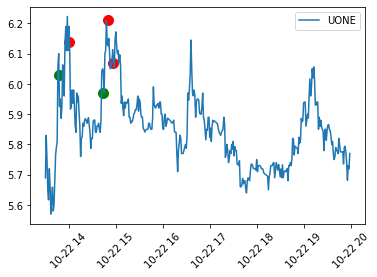

USEG analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1605.90,-1605.90,buy,2020-10-22 10:53:44.170941-04:00,5.30,303,4.95%,3.0%,"{'buy': {'avg': 5.2017, 'macd': [0.04199419706867147, 0.03858696041443199, 0.038668618757526474, 0.03988736966727213, 0.045963742947930264], 'vwap': 5.3299, 'macd_signal': [0.041228903444054485, 0.04070051483812999, 0.040294135622009286, 0.040212782431061855, 0.041362974534435534]}, 'sell': None}",6.25,5.02
1,0.00,1605.90,sell,2020-10-22 11:07:26.287763-04:00,5.30,303,4.95%,,"{'buy': None, 'sell': {'avg': 5.2176, 'rsi': [59.72941849068466, 57.820151371041675, 54.69467497014971], 'vwap': 5.3001, 'reasons': 'bail post whipsawed', 'movement': 1.8867924528257913e-05, 'sell_macd': [0.02010218559739929, 0.02175644536051724, 0.02276292770371935, 0.022472356442530206, 0.0206605819994925], 'sell_macd_signal': [0.02310683862095192, 0.022836759968864983, 0.022821993515835855, 0.022752066101174726, 0.02233376928083828]}}",6.25,5.02


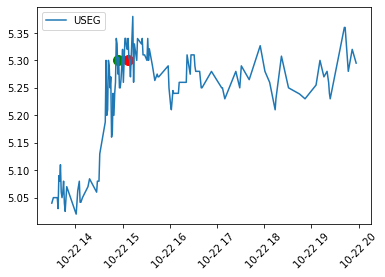

VIAO analysis with profit $65.52


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2265.48,-2265.48,buy,2020-10-22 12:45:07.108893-04:00,8.99,252,5.27%,2.49%,"{'buy': {'avg': 8.753, 'macd': [0.03858218097059307, 0.038323946543306064, 0.038634173740808464, 0.0454648739811212, 0.05189388557702301], 'vwap': 8.99, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.044404050548688935, 0.043188029747612364, 0.042277258546251584, 0.042914781633225506, 0.044710602421985005]}, 'sell': None}",10.10,8.62
1,65.52,2331.00,sell,2020-10-22 13:17:40.228181-04:00,9.25,252,8.31%,,"{'buy': None, 'sell': {'avg': 8.829, 'rsi': [71.02617894162519, 78.39315381776537, 81.5994538976405], 'vwap': 9.2891, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.033370411568409225, 'sell_macd': [0.03590685255197812, 0.03827564597222732, 0.03910489219615876, 0.0449574880564132, 0.05252369927146461], 'sell_macd_signal': [0.02983550626442353, 0.03152353420598429, 0.03303980580401918, 0.03542334225449799, 0.03884341365789131]}}",10.10,8.62


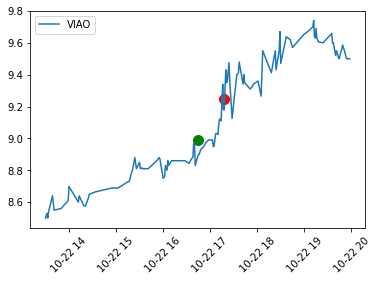

VVPR analysis with profit $-96.35


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1599.38,-1599.38,buy,2020-10-22 10:53:36.412968-04:00,7.58,211,4.84%,0.93%,"{'buy': {'avg': 7.2974, 'macd': [0.02879732543577518, 0.028253037556627447, 0.02823853238001206, 0.03508484846807658, 0.04705293260011434], 'vwap': 7.5878, 'macd_signal': [0.031358633084732, 0.030737513979111092, 0.030237717659291286, 0.031207143821048344, 0.03437630157686154]}, 'sell': None}",8.91,7.15
1,6.33,1605.71,sell,2020-10-22 10:54:44.297353-04:00,7.61,211,5.26%,,"{'buy': None, 'sell': {'avg': 7.3369, 'rsi': [68.08649938631271, 75.97500681242394, 79.20022849601284], 'vwap': 7.6899, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014498680738786235, 'sell_macd': [0.015894820753691086, 0.015893801039783106, 0.02036191813232513, 0.029812893553367026, 0.04042127838075782], 'sell_macd_signal': [0.017603268751045842, 0.017261375208793294, 0.017881483793499662, 0.020267765745473135, 0.02429846827253007]}}",8.91,7.15
2,-2482.15,-2488.48,buy,2020-10-22 12:53:05.549425-04:00,8.24,302,13.97%,8.35%,"{'buy': {'avg': 7.8337, 'macd': [0.0007891788680840506, 0.0050547730752086295, 0.0055471357950320765, 0.010257139227430656, 0.014229282780135577], 'vwap': 8.26, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.006013844049784488, 0.005822029854869316, 0.005767051042901868, 0.006665068679807626, 0.008177911499873215]}, 'sell': None}",9.19,7.94
3,-96.35,2385.80,sell,2020-10-22 13:35:46.202472-04:00,7.90,302,9.27%,,"{'buy': None, 'sell': {'avg': 7.875, 'rsi': [38.24542679213691, 32.976157674148716, 31.318921731844156], 'vwap': 7.9079, 'reasons': 'stopped', 'movement': -0.03701456310679619, 'sell_macd': [-0.03482177536473863, -0.034067462690034134, -0.03407621303844621, -0.037282041712034086, -0.04200240117571141], 'sell_macd_signal': [-0.026873369925828255, -0.028312188478669433, -0.029464993390624788, -0.031028403054906648, -0.0332232026790676]}}",9.19,7.94


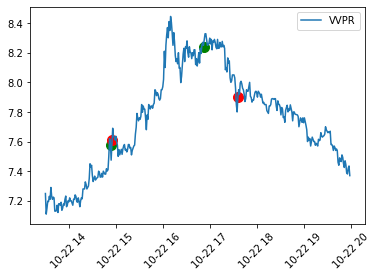

WBT analysis with profit $62.28


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3627.81,-3627.81,buy,2020-10-22 12:26:13.991606-04:00,6.99,519,2.49%,1.32%,"{'buy': {'avg': 6.9102, 'macd': [-0.001540723529726229, -0.0014130452333862564, -0.0019031771068140912, 0.0008456161787551153, 0.0029895925001692802], 'vwap': 6.9925, 'reason': ['MACD histogram reversal'], 'macd_signal': [-0.0014171371677474559, -0.001416318780875216, -0.001513690446062991, -0.0010418291210993699, -0.0002355447968456399]}, 'sell': None}",7.53,6.81
1,62.28,3690.09,sell,2020-10-22 13:15:11.688236-04:00,7.11,519,4.25%,,"{'buy': None, 'sell': {'avg': 6.9642, 'rsi': [72.18840534155053, 76.38612992677476, 81.41968254315498], 'vwap': 7.111, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.017882689556509297, 'sell_macd': [0.00920552734764879, 0.00897423647498119, 0.009456682074526768, 0.010489020436841301, 0.01224812798621766], 'sell_macd_signal': [0.009244504432589567, 0.009190450841067892, 0.009243697087759666, 0.009492761757575994, 0.010043835003304327]}}",7.53,6.81


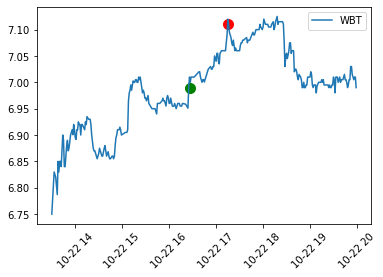

WES analysis with profit $3.83


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3519.77,-3519.77,buy,2020-10-22 12:35:22.879000-04:00,9.19,383,4.91%,4.1%,"{'buy': {'avg': 9.119, 'macd': [-0.00440323293926248, -0.003872340342654823, -0.004648736851379454, -0.004007466459624354, 0.00013036608616268097], 'vwap': 9.1761, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.007167410532781096, -0.006508396494755842, -0.006136464566080564, -0.005710664944789322, -0.004542458738598922]}, 'sell': None}",9.92,8.95
1,3.83,3523.60,sell,2020-10-22 14:35:06.071392-04:00,9.20,383,5.02%,,"{'buy': None, 'sell': {'avg': 9.1218, 'rsi': [62.56280946744944, 56.52046162625813, 56.52046162625813], 'vwap': 9.2, 'reasons': 'bail post whipsawed', 'movement': 0.0010881392818280508, 'sell_macd': [0.010364751686985585, 0.009346871542728508, 0.010250512059634787, 0.009782562955150453, 0.009290881017173902], 'sell_macd_signal': [0.01327679997663143, 0.012490814289850846, 0.012042753843807635, 0.011590715666076199, 0.011130748736295739]}}",9.92,8.95


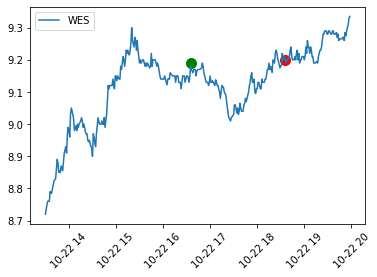

WIMI analysis with profit $-33.75


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1264.20,-1264.20,buy,2020-10-22 13:09:17.992156-04:00,5.88,215,4.81%,0.44%,"{'buy': {'avg': 5.6346, 'macd': [0.041101945714179244, 0.03827071466867604, 0.040139457129678036, 0.042741583477988065, 0.04588864448047669], 'vwap': 5.8773, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.04131878127087012, 0.0407091679504313, 0.04059522578628065, 0.041024497324622135, 0.04199732675579305]}, 'sell': None}",7.13,5.46
1,-1323.00,-58.80,buy,2020-10-22 13:09:18.110189-04:00,5.88,10,4.81%,0.44%,"{'buy': {'avg': 5.6346, 'macd': [0.041101945714179244, 0.03827071466867604, 0.040139457129678036, 0.042741583477988065, 0.04588864448047669], 'vwap': 5.8773, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.04131878127087012, 0.0407091679504313, 0.04059522578628065, 0.041024497324622135, 0.04199732675579305]}, 'sell': None}",7.13,5.46
2,-33.75,1289.25,sell,2020-10-22 15:45:12.509496-04:00,5.73,225,2.14%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.13,5.46


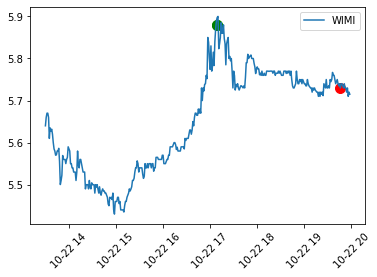

WPX analysis with profit $72.50


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3393.00,-3393.00,buy,2020-10-22 12:08:56.851781-04:00,4.68,725,4.46%,1.4%,"{'buy': {'avg': 4.5425, 'macd': [0.007439906649068462, 0.007597242553821104, 0.007235072763482897, 0.008304767967480586, 0.009207751184658441], 'vwap': 4.68, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.007658780679545162, 0.0076464730544003505, 0.00756419299621686, 0.0077123079904696055, 0.008011396629307372]}, 'sell': None}",5.07,4.55
1,72.50,3465.50,sell,2020-10-22 15:41:07.707576-04:00,4.78,725,6.7%,,"{'buy': None, 'sell': {'avg': 4.6179, 'rsi': [64.97297190000845, 57.143974233060135, 60.686681945400245], 'vwap': 4.79, 'reasons': 'bail', 'movement': 0.023504273504273573, 'sell_macd': [0.006828604116029702, 0.00672632758162095, 0.0064138221316714095, 0.005712989026105397, 0.00535243090454518], 'sell_macd_signal': [0.0063366451879229135, 0.006414581666662521, 0.006414429759664299, 0.006274141612952518, 0.006089799471271051]}}",5.07,4.55


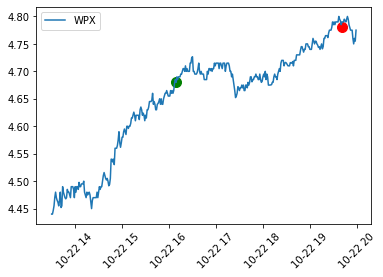

X analysis with profit $24.57


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3274.83,-3274.83,buy,2020-10-22 12:39:31.095896-04:00,9.33,351,4.42%,2.51%,"{'buy': {'avg': 9.1597, 'macd': [0.004418458564790839, 0.004629273053668115, 0.005539406649756273, 0.007385928337292569, 0.009147323638497795], 'vwap': 9.33, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.008321384593690346, 0.0075829622856859, 0.007174251158499975, 0.007216586594258494, 0.007602734003106354]}, 'sell': None}",10.13,9.06
1,24.57,3299.40,sell,2020-10-22 15:45:05.941907-04:00,9.40,351,5.2%,,"{'buy': None, 'sell': {'liquidation': 1}}",10.13,9.06


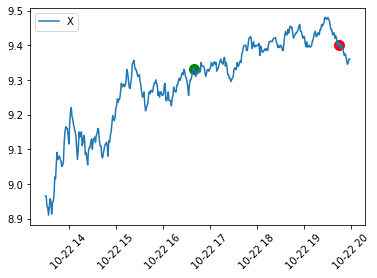

ZYXI analysis with profit $14.70


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2988.30,-2988.30,buy,2020-10-22 12:50:30.078205-04:00,14.23,210,2.37%,1.77%,"{'buy': {'avg': 14.146, 'macd': [-0.04654315325909586, -0.04695531278178855, -0.03996249972655619, -0.034028386937110966, -0.028991365384843704], 'vwap': 14.2382, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.03261001425288856, -0.035479073958668554, -0.03637575911224608, -0.035906284677219055, -0.03452330081874398]}, 'sell': None}",15.57,13.78
1,14.70,3003.00,sell,2020-10-22 15:39:42.479077-04:00,14.30,210,2.88%,,"{'buy': None, 'sell': {'avg': 14.1379, 'rsi': [73.68314634299061, 78.1651333373339, 82.23741258500358], 'vwap': 14.3032, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.008432888264230444, 'sell_macd': [0.023061288506029953, 0.024605424343299376, 0.02548909610814043, 0.02792456636505314, 0.02962591245660917], 'sell_macd_signal': [0.018798627812215064, 0.019959987118431926, 0.021065808916373628, 0.02243756040610953, 0.02387523081620946]}}",15.57,13.78


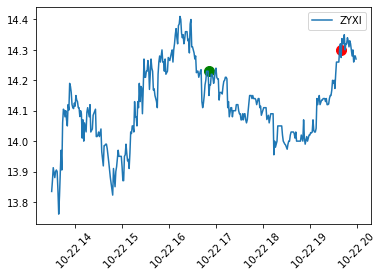

In [6]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(
        hour=9, minute=30, second=0, microsecond=0, tzinfo=None
    )
    end_date = start_date.replace(hour=16, minute=0, tzinfo=None)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        start_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
        end_index = minute_history[symbol]["close"].index.get_loc(
            end_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = float(minute_history[symbol]["close"][cool_minute_history_index])
    plt.plot(
        minute_history[symbol]["close"][start_index:end_index],
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()